### Import python libraries, including scikit learn classifiers

In [ ]:

# Standard library
import os
import warnings

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from utils import fmeasure_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder,
    StandardScaler, RobustScaler,
    PowerTransformer, PolynomialFeatures
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    classification_report,
    roc_auc_score, f1_score, recall_score, precision_score
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier,
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # adjust as needed
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

### Loading the dataset

In [ ]:
# Load the dataset
data_dir = 'C:/Users/ms201/OneDrive/Documents/Home/_SB/POND_dataset/Data_POND/Final_Data_POND/'

data_dict = pd.read_csv(data_dir+'data_dictionary_POND.csv')
nh0 = pd.read_csv(data_dir+'pond_9918_unweighted.csv')

pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_colwidth', None)  # Display full column width
pd.set_option('display.precision', 2)  # Display up to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format  # Set float format

In [ ]:
nh0.head()

,period,SEQN,SDDSRVYR,WTINT2YR,WTINT4YR,WTMEC2YR,WTMEC4YR,SDMVPSU,SDMVSTRA,preDM2,cohort,RIAGENDR,RIDAGEYR,DMDCITZN,DMDHRGND,RaceEth,EducGrp,CountBorn,NatAcc,HHRAge,HHREdu,HHSizCat,FamIncC,FamPIRCat,LangAcc,AccScore,FdInHH,FdInCH,FdInAD,FdStmp,WIC,Hager2Q,HIns4,RoutineHCplace,TypeHCplace,HOD050,HOQ065,Pesticide,BMXWT,BMXHT,BMXWAIST,bmipct,BMIcat,hypten,HTChol,MCQ010,MCQ053,MCQ092,AgeAsthma,StillAsthma,Rx30Days,HUQ020,HUQ090,HealthCond,TimesHCLastYr,OvntPT,MealsOut,InSchool,SchBkfst,SchLunch,NwkLunch,NwkBkfast,Milk30Days,SchMeal,NwkMeals,MilkType,WTDRD1,FTot,FCitMlB,FOther,VTot,VDrkGr,VRedOrTot,VRedOr,VTomato,VStarchTot,VStarchPot,VStarchOth,VOther,Legume,GTot,GRefine,GWhole,PTot,Pmps,PMeat,PFrank,POrgan,PPoult,PFishLow,PFishHigh,PEgg,PSoy,PNut,DTot,DMilk,DYogurt,DCheese,Oils,SolidFat,AddSugars,Alcohol,PAminWk,ScreenTime,PLimit,Smk5Days,HHSmkNum,HHSmk
0,1,6,1,36508.25,16850.98,39656.60,18337.31,2,2,0,1,2,19,0.00,1.00,3,2.00,0.00,3.00,0,1.00,0,0.00,1.00,2.00,5.00,0.00,NaN,0.00,NaN,0.00,0.00,0.00,1.00,0.00,4.00,1.00,0.00,59.20,162.00,81.60,61.15,1.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,1.00,1.00,0.00,0.00,3.00,0.00,1.00,0.00,2.00,2.00,0.00,0.00,2.00,2.00,2.00,3.00,87007.93,0.00,0.00,0.00,0.67,0.00,0.04,0.00,0.04,0.48,0.48,0.00,0.15,0.00,3.09,2.35,0.74,2.19,1.09,1.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.67,0.00,0.00,0.03,19.90,29.77,0.00,188.37,4.00,0.00,0.00,0.00,0.00
1,1,8,1,31600.09,14939.14,31510.59,14734.50,1,6,0,1,1,13,0.00,1.00,1,0.00,0.00,3.00,1,0.00,2,0.00,0.00,2.00,5.00,0.00,0.00,0.00,NaN,0.00,0.00,3.00,1.00,0.00,7.00,0.00,0.00,40.70,162.00,64.10,4.59,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,2.00,1.00,1.00,NaN,5.00,5.00,3.00,1.00,6.00,4.00,17873.98,0.00,0.00,0.00,5.29,0.00,1.39,0.00,1.39,2.48,2.23,0.25,1.42,0.00,10.54,8.59,1.95,28.94,14.45,14.45,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.00,7.67,6.10,0.00,1.56,28.91,161.06,84.58,0.00,278.84,9.00,0.00,0.00,2.00,1.00
2,1,11,1,36723.76,16028.65,38983.17,16137.98,2,1,0,1,1,15,0.00,0.00,1,0.00,0.00,3.00,2,1.00,1,1.00,1.00,2.00,5.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,1.00,0.00,7.00,0.00,1.00,65.00,171.90,76.50,73.84,1.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,NaN,5.00,NaN,3.00,1.00,6.00,4.00,120833.44,0.86,0.07,0.79,1.00,0.00,0.42,0.00,0.42,0.20,0.20,0.00,0.38,0.00,14.38,11.64,2.74,33.69,16.81,13.87,2.95,0.00,0.00,0.00,0.00,0.07,0.00,0.00,4.74,4.00,0.00,0.74,38.19,140.02,101.56,0.00,52.09,7.00,0.00,0.00,0.00,0.00
3,1,21,1,2823.15,1831.64,2910.63,1925.40,2,3,0,1,1,18,0.00,0.00,0,2.00,0.00,3.00,3,0.00,2,1.00,1.00,1.00,4.00,2.00,1.00,2.00,NaN,0.00,1.00,3.00,0.00,NaN,5.00,0.00,0.00,112.90,168.50,125.70,99.65,3.00,1.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,1.00,0.00,2.00,2.00,0.00,0.00,1.00,2.00,2.00,4.00,6289.12,0.27,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.57,1.57,0.00,7.72,3.10,3.10,0.00,0.00,0.00,0.00,0.00,1.52,0.00,0.00,0.67,0.00,0.00,0.67,0.00,38.55,24.21,0.00,0.00,3.00,0.00,0.00,0.00,0.00
4,1,22,1,7003.16,2985.14,6958.25,3105.04,2,2,0,1,2,13,0.00,1.00,2,0.00,0.00,3.00,1,1.00,1,0.00,0.00,2.00,5.00,2.00,0.00,2.00,0.00,1.00,1.00,3.00,1.00,0.00,6.00,1.00,0.00,50.90,162.20,66.90,56.49,1.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,3.00,1.00,1.00,NaN,5.00,5.00,3.00,1.00,6.00,4.00,6149.11,0.27,0.25,0.02,0.52,0.00,0.22,0.00,0.22,0.00,0.00,0.00,0.29,0.00,4.76,4.12,0.64,5.92,2.63,2.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,1.00,1.00,0.00,0.00,3.60,23.38,11.25,0.00,209.30,11.00,0.00,0.00,0.00,0.00


In [ ]:
nh0.shape

(15149, 108)

In [ ]:
# --- Extract feature groups from data dictionary ---

# Ensure consistent string formatting
data_dict['VariableNameNHANES'] = data_dict['VariableNameNHANES'].astype(str)
data_dict['Type'] = data_dict['Type'].astype(str).str.lower().str.strip()

# Create lists by feature type
cat_features = data_dict.loc[
    data_dict['Type'].str.contains('categorical', case=False, na=False), 'VariableNameNHANES'
].tolist()

binary_features = data_dict.loc[
    data_dict['Type'].str.contains('binary', case=False, na=False), 'VariableNameNHANES'
].tolist()

con_features = data_dict.loc[
    data_dict['Type'].str.contains('continuous|numeric|float|int', case=False, na=False), 'VariableNameNHANES'
].tolist()

ord_features = data_dict.loc[
    data_dict['Type'].str.contains('ordinal', case=False, na=False), 'VariableNameNHANES'
].tolist()

# Print summary
print(f"Categorical features: {len(cat_features)}")
print(f"Binary features: {len(binary_features)}")
print(f"Continuous features: {len(con_features)}")
print(f"Ordinal features: {len(ord_features)}")

overlap = set(cat_features) & set(binary_features) | set(cat_features) & set(con_features)
if overlap:
    print("\n⚠️ Warning: Some features appear in multiple categories:", overlap)



Categorical features: 13
Binary features: 20
Continuous features: 48
Ordinal features: 16


In [ ]:
cat_features

['preDM',
 'RIAGENDR',
 'DMDHRGND',
 'RaceEth',
 'LangAcc',
 'HOQ065',
 'HIns4',
 'HUQ020',
 'TypeHCplace',
 'SchBkfst',
 'SchLunch',
 'SchMeal',
 'MilkType']

In [ ]:
ord_features

['NatAcc',
 'EducGrp',
 'HHRAge',
 'HHREdu',
 'HHSizCat',
 'FamIncC',
 'FamPIRCat',
 'AccScore',
 'BMIcat',
 'FdInHH',
 'FdInCH',
 'FdInAD',
 'HealthCond',
 'TimesHCLastYr',
 'PLimit',
 'Milk30Days']

In [ ]:
binary_features

['DMDCITZN',
 'CountBorn',
 'HTChol',
 'hypten',
 'FdStmp',
 'WIC',
 'Hager2Q',
 'HUQ090',
 'OvntPT',
 'RoutineHCplace',
 'MCQ010',
 'MCQ053',
 'MCQ092',
 'StillAsthma',
 'Rx30Days',
 'InSchool',
 'HHSmk',
 'Smk5Days',
 'Pesticide',
 'cohort']

In [ ]:
con_features

['RIDAGEYR',
 'BMXWT',
 'BMXHT',
 'BMXWAIST',
 'HOD050',
 'PAminWk',
 'ScreenTime',
 'AgeAsthma',
 'MealsOut',
 'NwkLunch',
 'NwkBkfast',
 'NwkMeals',
 'GTot',
 'GRefine',
 'GWhole',
 'VTot',
 'VDrkGr',
 'VRedOrTot',
 'VRedOr',
 'VTomato',
 'VStarchTot',
 'VStarchPot',
 'VStarchOth',
 'VOther',
 'Legume',
 'FTot',
 'FCitMlB',
 'FOther',
 'DTot',
 'DMilk',
 'DYogurt',
 'DCheese',
 'PTot',
 'Pmps',
 'PMeat',
 'PFrank',
 'POrgan',
 'PPoult',
 'PFishLow',
 'PFishHigh',
 'PEgg',
 'PSoy',
 'PNut',
 'Oils',
 'SolidFat',
 'AddSugars',
 'Alcohol',
 'HHSmkNum']

In [ ]:
nh0.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 108 columns):
 #    Column          Dtype  
---   ------          -----  
 0    period          int64  
 1    SEQN            int64  
 2    SDDSRVYR        int64  
 3    WTINT2YR        float64
 4    WTINT4YR        float64
 5    WTMEC2YR        float64
 6    WTMEC4YR        float64
 7    SDMVPSU         int64  
 8    SDMVSTRA        int64  
 9    preDM2          int64  
 10   cohort          int64  
 11   RIAGENDR        int64  
 12   RIDAGEYR        int64  
 13   DMDCITZN        float64
 14   DMDHRGND        float64
 15   RaceEth         int64  
 16   EducGrp         float64
 17   CountBorn       float64
 18   NatAcc          float64
 19   HHRAge          int64  
 20   HHREdu          float64
 21   HHSizCat        int64  
 22   FamIncC         float64
 23   FamPIRCat       float64
 24   LangAcc         float64
 25   AccScore        float64
 26   FdInHH          float64
 27   FdInCH        

In [ ]:
# Step 1 - manually drop features not needed
nh1=nh0.copy(deep=True)
# make a list of drop columns
vars_to_drop=['period', 'SEQN', 'SDDSRVYR', 'WTINT4YR', 'WTINT2YR','WTMEC4YR','SDMVPSU','SDMVSTRA','cohort','bmipct', 'WTDRD1']
# Drop the columns
nh1.drop(columns=vars_to_drop, inplace=True)

# drop features with >75% values being 0 - causing skewness fix issue and not helpful during modeling
cols_to_drop = [
    "AgeAsthma",
    "VDrkGr",
    "VRedOr",
    "VStarchOth",
    "Legume",
    "DYogurt",
    "POrgan",
    "PFishLow",
    "PFishHigh",
    "PSoy",
    "Alcohol",
    "HHSmkNum"
]

nh1.drop(columns=cols_to_drop, inplace=True)

nh1.shape

(15149, 85)

In [ ]:
nh1.head()

,WTMEC2YR,preDM2,RIAGENDR,RIDAGEYR,DMDCITZN,DMDHRGND,RaceEth,EducGrp,CountBorn,NatAcc,HHRAge,HHREdu,HHSizCat,FamIncC,FamPIRCat,LangAcc,AccScore,FdInHH,FdInCH,FdInAD,FdStmp,WIC,Hager2Q,HIns4,RoutineHCplace,TypeHCplace,HOD050,HOQ065,Pesticide,BMXWT,BMXHT,BMXWAIST,BMIcat,hypten,HTChol,MCQ010,MCQ053,MCQ092,StillAsthma,Rx30Days,HUQ020,HUQ090,HealthCond,TimesHCLastYr,OvntPT,MealsOut,InSchool,SchBkfst,SchLunch,NwkLunch,NwkBkfast,Milk30Days,SchMeal,NwkMeals,MilkType,FTot,FCitMlB,FOther,VTot,VRedOrTot,VTomato,VStarchTot,VStarchPot,VOther,GTot,GRefine,GWhole,PTot,Pmps,PMeat,PFrank,PPoult,PEgg,PNut,DTot,DMilk,DCheese,Oils,SolidFat,AddSugars,PAminWk,ScreenTime,PLimit,Smk5Days,HHSmk
0,39656.60,0,2,19,0.00,1.00,3,2.00,0.00,3.00,0,1.00,0,0.00,1.00,2.00,5.00,0.00,NaN,0.00,NaN,0.00,0.00,0.00,1.00,0.00,4.00,1.00,0.00,59.20,162.00,81.60,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,3.00,0.00,1.00,0.00,2.00,2.00,0.00,0.00,2.00,2.00,2.00,3.00,0.00,0.00,0.00,0.67,0.04,0.04,0.48,0.48,0.15,3.09,2.35,0.74,2.19,1.09,1.09,0.00,0.00,0.00,0.00,0.67,0.67,0.00,0.03,19.90,29.77,188.37,4.00,0.00,0.00,0.00
1,31510.59,0,1,13,0.00,1.00,1,0.00,0.00,3.00,1,0.00,2,0.00,0.00,2.00,5.00,0.00,0.00,0.00,NaN,0.00,0.00,3.00,1.00,0.00,7.00,0.00,0.00,40.70,162.00,64.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,2.00,1.00,1.00,NaN,5.00,5.00,3.00,1.00,6.00,4.00,0.00,0.00,0.00,5.29,1.39,1.39,2.48,2.23,1.42,10.54,8.59,1.95,28.94,14.45,14.45,0.00,0.00,0.01,0.00,7.67,6.10,1.56,28.91,161.06,84.58,278.84,9.00,0.00,0.00,1.00
2,38983.17,0,1,15,0.00,0.00,1,0.00,0.00,3.00,2,1.00,1,1.00,1.00,2.00,5.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,1.00,0.00,7.00,0.00,1.00,65.00,171.90,76.50,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,NaN,5.00,NaN,3.00,1.00,6.00,4.00,0.86,0.07,0.79,1.00,0.42,0.42,0.20,0.20,0.38,14.38,11.64,2.74,33.69,16.81,13.87,2.95,0.00,0.07,0.00,4.74,4.00,0.74,38.19,140.02,101.56,52.09,7.00,0.00,0.00,0.00
3,2910.63,0,1,18,0.00,0.00,0,2.00,0.00,3.00,3,0.00,2,1.00,1.00,1.00,4.00,2.00,1.00,2.00,NaN,0.00,1.00,3.00,0.00,NaN,5.00,0.00,0.00,112.90,168.50,125.70,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,0.00,1.00,0.00,2.00,2.00,0.00,0.00,1.00,2.00,2.00,4.00,0.27,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.57,1.57,0.00,7.72,3.10,3.10,0.00,0.00,1.52,0.00,0.67,0.00,0.67,0.00,38.55,24.21,0.00,3.00,0.00,0.00,0.00
4,6958.25,0,2,13,0.00,1.00,2,0.00,0.00,3.00,1,1.00,1,0.00,0.00,2.00,5.00,2.00,0.00,2.00,0.00,1.00,1.00,3.00,1.00,0.00,6.00,1.00,0.00,50.90,162.20,66.90,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,3.00,1.00,1.00,NaN,5.00,5.00,3.00,1.00,6.00,4.00,0.27,0.25,0.02,0.52,0.22,0.22,0.00,0.00,0.29,4.76,4.12,0.64,5.92,2.63,2.63,0.00,0.00,0.00,0.67,1.00,1.00,0.00,3.60,23.38,11.25,209.30,11.00,0.00,0.00,0.00


In [ ]:
# Step 2 - split into train and test
X = nh1.drop(columns=["WTMEC2YR", "preDM2"])
y = nh1["preDM2"]

We need to use MEC(Mobile Examination Center) weights since we used some features from the lab results.  
WTMEC2YR is adjusted for:  
* Unequal probability of selection  
* Oversampling  
* Nonresponse  
* Post-stratification to match the U.S. population  
These weights are REQUIRED for nationally representative analysis.

In [ ]:
# Build combined MEC weight for 1999–2018 cycles: divide by 10 survey cycles (NHANES MEC weights are 2-year weights; for 10 cycles → divide by 10)
w_mec2yr = nh1["WTMEC2YR"].astype(float) / 10.0

# Normalize once on the full dataset to perserve the “probability of selection” interpretation so that weighting does not distort model optimization.
w_mec2yr_norm = w_mec2yr / w_mec2yr.mean()

# split X, y, and w using the same indices
# using stratify=y to preserve the same Y/N distribution as the full data 13% Yes
# two-step stratified data split that ensures your training, validation, and test sets have the same class proportions as your original dataset.
# Split into train/validation/test (60/20/20) with stratify
# Splits the whole dataset into:
# 60% goes to TRAIN
# 40% goes to TEMP (which will later become validation + test)
# After this step:
# X_test = 20% holdout for final evaluation.
# X_temp = 80% left for training and validation.
X_train, X_temp, y_train, y_temp, w_train_norm, w_temp_norm = train_test_split(
    X, y, w_mec2yr_norm,
    test_size=0.4,
    stratify=y,
    random_state=42
)

# split the TEMP = 40% into:
# 50% validation
# 50% test
# So:
# Val = 40% × 0.5 = 20%
# Test = 40% × 0.5 = 20%
X_val, X_test, y_val, y_test, w_val_norm, w_test_norm = train_test_split(
    X_temp, y_temp, w_temp_norm,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)
print('Shapes: X_train, X_val, X_test:', X_train.shape, X_val.shape, X_test.shape)
print('Class proportions (train, val, test):')
print(y_train.value_counts(normalize=True))
print(y_val.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Shapes: X_train, X_val, X_test: (9089, 83) (3030, 83) (3030, 83)
Class proportions (train, val, test):
preDM2
0   0.87
1   0.13
Name: proportion, dtype: float64
preDM2
0   0.87
1   0.13
Name: proportion, dtype: float64
preDM2
0   0.87
1   0.13
Name: proportion, dtype: float64


Normalizing weights separately inside each split is okay for pure predictive modeling, because most ML algorithms only care about relative weights inside the sample they’re trained on. Normalizing within each split keeps the numeric scale reasonable and stable for the optimizer.  

But from a strict survey-inference standpoint, it slightly breaks the “probability of selection” interpretation, because each split’s weights now sum to different effective “population sizes.” For prediction, that’s usually acceptable; for official prevalence estimates, you’d instead keep one consistent weight (only normalized once, if at all).  

**Normalizing the weights ONCE on the full dataset and then split:**    
* The relative weights across the entire dataset are preserved.
* Each split still carries the correct relative survey weights.  
* No further normalization per split is really necessary (unless a specific algorithm is super sensitive).

| Dataset            | Weight Name     | Description                                       |
|--------------------|-----------------|---------------------------------------------------|
| **Training set**   | `w_train_norm`  | Survey weights (normalized) for rows in `X_train` |
| **Validation set** | `w_val_norm`    | Survey weights (normalized) for rows in `X_val`   |
| **Test set**       | `w_test_norm`   | Survey weights (normalized) for rows in `X_test`  |


Each training observation’s weight is:  
$w_{\text{train\_final}, i} = w_{\text{survey}, i} \times w_{\text{class}, y_i}$
* survey weight for representativeness
* inverse-frequency class weight for imbalance


In [ ]:
# Compute class imbalance ratio (for weighted models)
# Fraction of positives in training set
pos_rate = y_train.mean()
neg_rate = 1 - pos_rate

# Compute class weights for binary {0,1} target
# This is the standard and correct version
# Because model training uses the absolute differences in weights.
# - It matches: class_weight="balanced" in scikit-learn
# - Statistical definition of inverse-frequency weighting
class_weight_ratio = {
    0: 1 / neg_rate,
    1: 1 / pos_rate
}

# use sample_weight=w_train for survey adjustment,
# and class_weight (or scale_pos_weight) where models support it,
# so both survey weighting and imbalance correction are handled together.

w_train_final = w_train_norm * y_train.map(class_weight_ratio)


First 10 final weights:
1026    0.46
948     0.39
4908    0.30
5962    3.02
1510    0.11
3458    1.97
13950   1.01
1817    2.67
2473    1.66
5116    2.26
dtype: float64

Summary statistics for w_train_final:
count   9089.00
mean       1.96
std        3.41
min        0.06
25%        0.38
50%        0.92
75%        2.15
max       48.24
dtype: float64

Average weights by class:
        mean_weight  count
preDM2                    
0              1.15   7883
1              7.27   1206


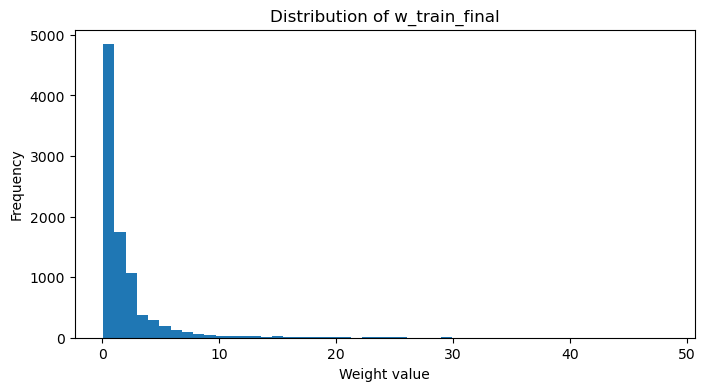

In [ ]:
# Inspect w_train_final

print("First 10 final weights:")
print(w_train_final.head(10))

print("\nSummary statistics for w_train_final:")
print(w_train_final.describe())

# Class-wise average weights to verify imbalance weighting
print("\nAverage weights by class:")
print(pd.DataFrame({
    "mean_weight": w_train_final.groupby(y_train).mean(),
    "count": y_train.value_counts()
}))

# Check distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(w_train_final, bins=50)
plt.title("Distribution of w_train_final")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()


Expected Output Interpretation  
1. First 10 values  
Helpful for sanity check.  
You should see a mix of small and larger numbers — positive class cases should have higher weights.  

2. Summary statistics  
Look at:  
min > 0 (never negative)  
max should be noticeably higher for minority class  
mean should be reasonable (around 1–5 depending on normalization)  
                               
3. Class-wise mean weights  
Example expected pattern (your actual numbers may vary):  
| Class         | Mean weight | Interpretation                 |
| ------------- | ----------- | ------------------------------ |
| 0 (non-preDM) | ~1.1        | Majority class, low weight     |
| 1 (preDM)     | ~7–8        | Minority class, boosted weight |


### Pipelines for preprocessing
| Feature Type                   | Steps Included                                                    |
| ------------------------------ | ----------------------------------------------------------------- |
| **Continuous (con_features)**  | Impute → Remove Correlated → Clip Outliers → Fix Skewness → Scale |
| **Ordinal (ord_features)**     | Impute → Scale                                                    |
| **Categorical (cat_features)** | Impute → One-Hot Encode                                           |
| **Binary (bin_features)**      | Impute → Leave as-is or optionally encode as 0/1                  |


In [ ]:
# Filter only features that exist in nh1
available_cols = nh1.columns.tolist()
con_features = [f for f in con_features if f in available_cols]
ord_features = [f for f in ord_features if f in available_cols]
cat_features = [f for f in cat_features if f in available_cols]
binary_features = [f for f in binary_features if f in available_cols]

print(f"Continuous: {len(con_features)} | Ordinal: {len(ord_features)} | "
      f"Categorical: {len(cat_features)} | Binary: {len(binary_features)}")

Continuous: 36 | Ordinal: 16 | Categorical: 12 | Binary: 19


✅ Pipeline 1 — Tree-Based Models  
(Random Forest, XGBoost, LightGBM, CatBoost, AdaBoost, GradientBoostingClassifier)  
Trees only need:  
👉 Imputation  
👉 Categorical encoding (OneHotEncoder or CatBoost native encoding)  

In [ ]:
# Tree models do NOT need scaling.
# Missing value imputation
# Encoding for categorical variables

# Continuous uses median imputation
con_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])


# Ordinal uses impute + ordinal encode
ord_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])


# Categorical uses impute + one-hot encode (dense output)
cat_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False  # tree models prefer dense
    ))
])


# Binary uses impute only
bin_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('continuous',  con_tree,  con_features),
        ('ordinal',     ord_tree,  ord_features),
        ('categorical', cat_tree,  cat_features),
        ('binary',      bin_tree,  binary_features)
    ],
    remainder='drop',
    sparse_threshold=0  # ensures final output is ALWAYS dense
)


In [ ]:
# Fit only on training data for tree models
tree_preprocessor.fit(X_train)

X_train_tree_prep = tree_preprocessor.fit_transform(X_train)
X_val_tree_prep   = tree_preprocessor.transform(X_val)
X_test_tree_prep  = tree_preprocessor.transform(X_test)
print("Shapes after preprocessing:",
      X_train_tree_prep.shape, X_val_tree_prep.shape, X_test_tree_prep.shape)

Shapes after preprocessing: (9089, 109) (3030, 109) (3030, 109)


Pipeline 2 — Non-Tree Models  
(Logistic Regression, Linear SVM, KNN, Neural Networks, PCA, GB, SGDClassifier, LogReg Poly2, NGBoost,TabNet, MLP)
* imputation  
* outlier clipping  
* skewness transform  
* StandardScaler  
* ordinal encoding + scaling

In [ ]:
# Full correlation table for all continuous features in training data

train_cont = X_train[con_features].copy()

# Compute absolute correlation matrix
corr_abs = train_cont.corr().abs()

# Extract upper triangle (to avoid duplicates)
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

# Convert to long-form table
corr_table = (
    upper.stack()  # convert matrix → long format
         .reset_index()  # remove matrix index
         .rename(columns={
             "level_0": "Feature_1",
             "level_1": "Feature_2",
             0: "Correlation"
         })
)

# Sort by correlation descending
corr_table = corr_table.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

# Display the FULL TABLE
print("Full feature–feature correlation table")
display(corr_table)


📊 FULL FEATURE–FEATURE CORRELATION TABLE


,Feature_1,Feature_2,Correlation
0,GTot,GRefine,0.98
1,NwkLunch,NwkMeals,0.98
2,VStarchTot,VStarchPot,0.95
3,BMXWT,BMXWAIST,0.91
4,PTot,Pmps,0.86
...,...,...,...
625,HOD050,VTot,0.00
626,MealsOut,PNut,0.00
627,DMilk,PPoult,0.00
628,ScreenTime,DCheese,0.00


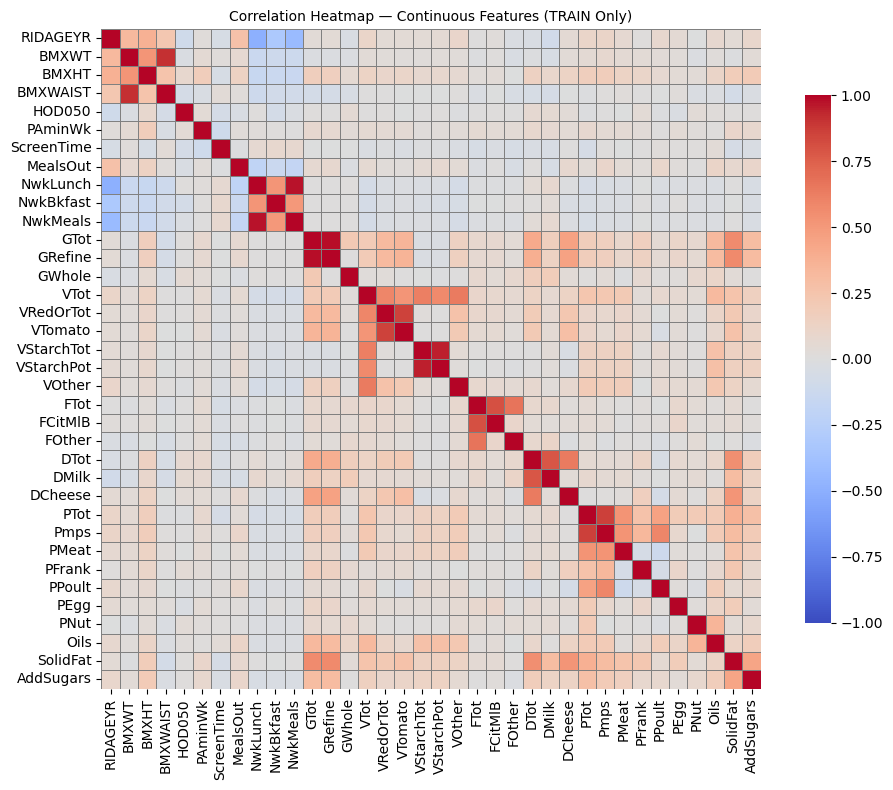

In [ ]:
# Correlation Heatmap Block (TRAIN Only)
train_cont = X_train[con_features].copy()

# Compute correlation
corr = train_cont.corr()

# Set plot size
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    center=0,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8},
)

plt.title("Correlation Heatmap — Continuous Features (TRAIN Only)", fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
train_cont = X_train[con_features].copy()

# Compute absolute Pearson correlations among TRAIN continuous features
corr = train_cont.corr().abs()

# Extract upper triangle (to avoid duplicates)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Tunable correlation threshold:
#   - Higher (e.g. 0.85–0.90)  → keep more features, less aggressive filtering
#   - Lower (e.g. 0.60–0.70)  → drop more correlated features
CORR_THRESHOLD = 0.85

# Identify columns to drop
to_drop = [col for col in upper.columns if any(upper[col] > CORR_THRESHOLD)]

print("Correlation filter - train only")
print(f"Threshold: r > {CORR_THRESHOLD}")
print(f"Total continuous features before:  {len(con_features)}")
print(f"Dropped (due to high correlation): {len(to_drop)}")
print(f"Remaining continuous features:     {len(con_features) - len(to_drop)}\n")

if len(to_drop) > 0:
    print("📉 Dropped features:")
    for f in to_drop:
        print("   •", f)
else:
    print("✔ No features exceeded the correlation threshold.")

con_features_filtered = [f for f in con_features if f not in to_drop]

print("\nFinal continuous feature list (after filter) - con_features_filtered")
print(con_features_filtered)
print(f"\nFinal count: {len(con_features_filtered)}")


🔍 CORRELATION FILTER — TRAIN ONLY
Threshold: r > 0.85
Total continuous features before:  36
Dropped (due to high correlation): 6
Remaining continuous features:     30

📉 Dropped features:
   • BMXWAIST
   • NwkMeals
   • GRefine
   • VTomato
   • VStarchPot
   • Pmps

✨ FINAL continuous feature list (after filter) - con_features_filtered
['RIDAGEYR', 'BMXWT', 'BMXHT', 'HOD050', 'PAminWk', 'ScreenTime', 'MealsOut', 'NwkLunch', 'NwkBkfast', 'GTot', 'GWhole', 'VTot', 'VRedOrTot', 'VStarchTot', 'VOther', 'FTot', 'FCitMlB', 'FOther', 'DTot', 'DMilk', 'DCheese', 'PTot', 'PMeat', 'PFrank', 'PPoult', 'PEgg', 'PNut', 'Oils', 'SolidFat', 'AddSugars']

Final count: 30


In [ ]:
# enforce consistent columns across all datasets
# Update the continuous feature list
# Build updated final feature lists AFTER correlation filtering
con_features_nontree = con_features_filtered
final_features_nontree = con_features_nontree + ord_features + cat_features + binary_features

# Subset all splits
X_train_nontree = X_train[final_features_nontree].copy()
X_val_nontree   = X_val[final_features_nontree].copy()
X_test_nontree  = X_test[final_features_nontree].copy()

print("Shapes:", X_train_nontree.shape, X_val_nontree.shape, X_test_nontree.shape)


Shapes: (9089, 77) (3030, 77) (3030, 77)


In [ ]:
X_train_nontree.head(2)

,RIDAGEYR,BMXWT,BMXHT,HOD050,PAminWk,ScreenTime,MealsOut,NwkLunch,NwkBkfast,GTot,GWhole,VTot,VRedOrTot,VStarchTot,VOther,FTot,FCitMlB,FOther,DTot,DMilk,DCheese,PTot,PMeat,PFrank,PPoult,PEgg,PNut,Oils,SolidFat,AddSugars,NatAcc,EducGrp,HHRAge,HHREdu,HHSizCat,FamIncC,FamPIRCat,AccScore,BMIcat,FdInHH,FdInCH,FdInAD,HealthCond,TimesHCLastYr,PLimit,Milk30Days,RIAGENDR,DMDHRGND,RaceEth,LangAcc,HOQ065,HIns4,HUQ020,TypeHCplace,SchBkfst,SchLunch,SchMeal,MilkType,DMDCITZN,CountBorn,HTChol,hypten,FdStmp,WIC,Hager2Q,HUQ090,OvntPT,RoutineHCplace,MCQ010,MCQ053,MCQ092,StillAsthma,Rx30Days,InSchool,HHSmk,Smk5Days,Pesticide
1026,12,52.10,153.80,6.00,6.98,9.00,6.00,5.00,NaN,9.35,0.37,0.48,0.00,0.48,0.00,0.00,0.00,0.00,0.75,0.75,0.00,12.08,0.00,6.03,0.00,0.01,0.00,9.25,79.33,1.95,3.00,0.00,1,0.00,2,0.00,0.00,5.00,2.00,1.00,0.00,1.00,0.00,2.00,0.00,2.00,1,1.00,2,2.00,1.00,2.00,1.00,0.00,1.00,NaN,1.00,4.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
948,12,78.10,156.40,5.00,153.49,9.00,2.00,2.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,0.00,1,1.00,1,NaN,NaN,5.00,3.00,1.00,0.00,1.00,0.00,1.00,0.00,3.00,2,1.00,2,2.00,0.00,0.00,1.00,0.00,1.00,NaN,1.00,1.00,0.00,0.00,0.00,1.00,NaN,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [ ]:
# Outlier Clipper (IQR-based)
class IQRClipper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.bounds_ = {}

        for col in X_df.columns:
            q1 = X_df[col].quantile(0.25)
            q3 = X_df[col].quantile(0.75)
            iqr = q3 - q1
            self.bounds_[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)

        for col, (low, high) in self.bounds_.items():
            X_df[col] = X_df[col].clip(lower=low, upper=high)

        return X_df.values

# Skewness Fixer
class SafeSkewFixer(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0):
        self.skew_threshold = skew_threshold
        self.transform_map_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.transform_map_ = {}

        for col in X_df.columns:
            sk = X_df[col].skew()

            if sk > self.skew_threshold:
                self.transform_map_[col] = "log"
            elif 0.5 < sk <= self.skew_threshold:
                self.transform_map_[col] = "sqrt"
            else:
                self.transform_map_[col] = "none"

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)

        for col in X_df.columns:
            action = self.transform_map_.get(col, "none")

            if action == "log":
                X_df[col] = np.log1p(X_df[col])
            elif action == "sqrt":
                X_df[col] = np.sqrt(X_df[col])

        return X_df.values


In [ ]:
#  NON-TREE PREPROCESSOR (with con_features_filtered)

# --- Continuous block ---
# avoid over-transforming continuous variables here.
# Strategy:
#   - Median imputation for missing values
#   - Gentle IQR clipping for extreme outliers
#   - StandardScaler for scale normalization

con_non_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clip', IQRClipper()),
    ('scale', StandardScaler())
])

# --- Ordinal ---
ord_non_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# --- Categorical (one-hot) ---
cat_non_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    )),
])

# --- Binary ---
bin_non_tree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

# APPLY PREPROCESSOR WITH FILTERED FEATURE LIST (con_features_filtered)
non_tree_preprocessor = ColumnTransformer([
    ('continuous',  con_non_tree,  con_features_nontree),
    ('ordinal',     ord_non_tree,  ord_features),
    ('categorical', cat_non_tree,  cat_features),
    ('binary',      bin_non_tree,  binary_features),
])


In [ ]:
def get_feature_names(ct):
    """
    Safe extraction of feature names from a FITTED ColumnTransformer.
    Works with pipelines, OHE, ordinal encoders, passthrough,
    and custom transformers.
    """

    # Must be fitted
    if not hasattr(ct, "transformers_"):
        raise RuntimeError(
            "ColumnTransformer is NOT fitted.\n"
            "Run non_tree_preprocessor.fit(X_train_nontree) first."
        )

    feature_names = []

    for name, trans, cols in ct.transformers_:

        if trans == "drop":
            continue

        # If transformer is a Pipeline, get last step
        if hasattr(trans, "named_steps"):
            last_step = list(trans.named_steps.values())[-1]
        else:
            last_step = trans

        # If last step can output feature names (e.g. OHE)
        if hasattr(last_step, "get_feature_names_out"):
            try:
                out = last_step.get_feature_names_out(cols)
            except:
                out = cols
        else:
            out = cols

        # Prefix with transformer name for clarity
        out = [f"{name}__{c}" for c in out]
        feature_names.extend(out)

    return feature_names


In [ ]:
# 1. Fit non-tree preprocessor on TRAIN ONLY
non_tree_preprocessor.fit(X_train_nontree)

# Transform splits
X_train_non_tree_prep = non_tree_preprocessor.transform(X_train_nontree)
X_val_non_tree_prep   = non_tree_preprocessor.transform(X_val_nontree)
X_test_non_tree_prep  = non_tree_preprocessor.transform(X_test_nontree)

# 2. NOW extract feature names
non_tree_feature_names = get_feature_names(non_tree_preprocessor)
non_tree_feature_names = non_tree_feature_names[:X_train_non_tree_prep.shape[1]]

# Convert arrays → DataFrames
X_train_non_tree_df = pd.DataFrame(X_train_non_tree_prep, columns=non_tree_feature_names)
X_val_non_tree_df   = pd.DataFrame(X_val_non_tree_prep,   columns=non_tree_feature_names)
X_test_non_tree_df  = pd.DataFrame(X_test_non_tree_prep,  columns=non_tree_feature_names)

print("Shapes after preprocessing:")
print("X_train_non_tree_df:", X_train_non_tree_df.shape)
print("X_val_non_tree_df:  ", X_val_non_tree_df.shape)
print("X_test_non_tree_df: ", X_test_non_tree_df.shape)# ============================================================
# 3. Add a few simple interaction / ratio features (NON-TREE ONLY)
# Do this *after* preprocessing so everything stays numeric and scaled.
# Each new feature is created only if the underlying columns exist,
# so this cell is safe to re-run.

def _find_col(df, key):
    """Return the first column name containing the substring `key`, or None."""
    for col in df.columns:
        if key in col:
            return col
    return None

# Example biological / dietary ratios
waist_col  = _find_col(X_train_non_tree_df, "BMXWAIST")
height_col = _find_col(X_train_non_tree_df, "BMXHT")
bmi_col    = _find_col(X_train_non_tree_df, "BMXBMI")
age_col    = _find_col(X_train_non_tree_df, "RIDAGEYR")
kcal_col   = _find_col(X_train_non_tree_df, "KCAL")
ftot_col   = _find_col(X_train_non_tree_df, "FTot")

def _add_ratio_feature(df, num_col, den_col, new_name, eps=1e-6):
    if num_col is not None and den_col is not None and num_col in df.columns and den_col in df.columns:
        df[new_name] = df[num_col] / (df[den_col] + eps)

# 1) Waist-to-height ratio
if waist_col and height_col:
    _add_ratio_feature(X_train_non_tree_df, waist_col, height_col, "int_waist_over_height")
    _add_ratio_feature(X_val_non_tree_df,   waist_col, height_col, "int_waist_over_height")
    _add_ratio_feature(X_test_non_tree_df,  waist_col, height_col, "int_waist_over_height")

# 2) BMI × age (multiplicative interaction)
if bmi_col and age_col and bmi_col in X_train_non_tree_df.columns and age_col in X_train_non_tree_df.columns:
    for df in (X_train_non_tree_df, X_val_non_tree_df, X_test_non_tree_df):
        df["int_bmi_x_age"] = df[bmi_col] * df[age_col]

# 3) Total food energy ratios (if available)
if ftot_col and kcal_col and ftot_col in X_train_non_tree_df.columns and kcal_col in X_train_non_tree_df.columns:
    _add_ratio_feature(X_train_non_tree_df, ftot_col, kcal_col, "int_ftot_over_kcal")
    _add_ratio_feature(X_val_non_tree_df,   ftot_col, kcal_col, "int_ftot_over_kcal")
    _add_ratio_feature(X_test_non_tree_df,  ftot_col, kcal_col, "int_ftot_over_kcal")

print("\nAfter adding simple interaction / ratio features (non-tree only):")
print("X_train_non_tree_df:", X_train_non_tree_df.shape)
print("X_val_non_tree_df:  ", X_val_non_tree_df.shape)
print("X_test_non_tree_df: ", X_test_non_tree_df.shape)


Shapes after preprocessing:
X_train_non_tree_df: (9089, 103)
X_val_non_tree_df:   (3030, 103)
X_test_non_tree_df:  (3030, 103)

After adding simple interaction / ratio features (non-tree only):
X_train_non_tree_df: (9089, 103)
X_val_non_tree_df:   (3030, 103)
X_test_non_tree_df:  (3030, 103)


In [ ]:
# Tree feature names
tree_feature_names = get_feature_names(tree_preprocessor)
tree_feature_names = tree_feature_names[:X_train_tree_prep.shape[1]]
X_train_tree_df = pd.DataFrame(X_train_tree_prep, columns=tree_feature_names)
X_val_tree_df   = pd.DataFrame(X_val_tree_prep,   columns=tree_feature_names)
X_test_tree_df  = pd.DataFrame(X_test_tree_prep,  columns=tree_feature_names)

print("Shapes after preprocessing:")
print("X_train_tree_df:", X_train_tree_df.shape)
print("X_val_tree_df:  ", X_val_tree_df.shape)
print("X_test_tree_df: ", X_test_tree_df.shape)

# Display a few rows for each
print("\n--- X_train_tree_df ---")
display(X_train_tree_df.head(2))
print("\n--- X_val_tree_df ---")
display(X_val_tree_df.head(2))
print("\n--- X_test_tree_df ---")
display(X_test_tree_df.head(2))

# Display a few rows for each
print("\n--- X_train_non_tree_df ---")
display(X_train_non_tree_df.head(2))
print("\n--- X_val_non_tree_df ---")
display(X_val_non_tree_df.head(2))
print("\n--- X_test_non_tree_df ---")
display(X_test_non_tree_df.head(2))


Shapes after preprocessing:
X_train_tree_df: (9089, 109)
X_val_tree_df:   (3030, 109)
X_test_tree_df:  (3030, 109)

--- X_train_tree_df ---


,continuous__RIDAGEYR,continuous__BMXWT,continuous__BMXHT,continuous__BMXWAIST,continuous__HOD050,continuous__PAminWk,continuous__ScreenTime,continuous__MealsOut,continuous__NwkLunch,continuous__NwkBkfast,continuous__NwkMeals,continuous__GTot,continuous__GRefine,continuous__GWhole,continuous__VTot,continuous__VRedOrTot,continuous__VTomato,continuous__VStarchTot,continuous__VStarchPot,continuous__VOther,continuous__FTot,continuous__FCitMlB,continuous__FOther,continuous__DTot,continuous__DMilk,continuous__DCheese,continuous__PTot,continuous__Pmps,continuous__PMeat,continuous__PFrank,continuous__PPoult,continuous__PEgg,continuous__PNut,continuous__Oils,continuous__SolidFat,continuous__AddSugars,ordinal__NatAcc,ordinal__EducGrp,ordinal__HHRAge,ordinal__HHREdu,ordinal__HHSizCat,ordinal__FamIncC,ordinal__FamPIRCat,ordinal__AccScore,ordinal__BMIcat,ordinal__FdInHH,ordinal__FdInCH,ordinal__FdInAD,ordinal__HealthCond,ordinal__TimesHCLastYr,ordinal__PLimit,ordinal__Milk30Days,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,categorical__DMDHRGND_0.0,categorical__DMDHRGND_1.0,categorical__RaceEth_0.0,categorical__RaceEth_1.0,categorical__RaceEth_2.0,categorical__RaceEth_3.0,categorical__LangAcc_0.0,categorical__LangAcc_1.0,categorical__LangAcc_2.0,categorical__HOQ065_0.0,categorical__HOQ065_1.0,categorical__HOQ065_2.0,categorical__HIns4_0.0,categorical__HIns4_1.0,categorical__HIns4_2.0,categorical__HIns4_3.0,categorical__HUQ020_0.0,categorical__HUQ020_1.0,categorical__HUQ020_2.0,categorical__TypeHCplace_0.0,categorical__TypeHCplace_1.0,categorical__TypeHCplace_2.0,categorical__SchBkfst_0.0,categorical__SchBkfst_1.0,categorical__SchBkfst_2.0,categorical__SchLunch_0.0,categorical__SchLunch_1.0,categorical__SchLunch_2.0,categorical__SchMeal_0.0,categorical__SchMeal_1.0,categorical__SchMeal_2.0,categorical__MilkType_0.0,categorical__MilkType_1.0,categorical__MilkType_2.0,categorical__MilkType_3.0,categorical__MilkType_4.0,binary__DMDCITZN,binary__CountBorn,binary__HTChol,binary__hypten,binary__FdStmp,binary__WIC,binary__Hager2Q,binary__HUQ090,binary__OvntPT,binary__RoutineHCplace,binary__MCQ010,binary__MCQ053,binary__MCQ092,binary__StillAsthma,binary__Rx30Days,binary__InSchool,binary__HHSmk,binary__Smk5Days,binary__Pesticide
0,12.00,52.10,153.80,69.30,6.00,6.98,9.00,6.00,5.00,0.00,6.00,9.35,8.98,0.37,0.48,0.00,0.00,0.48,0.48,0.00,0.00,0.00,0.00,0.75,0.75,0.00,12.08,6.03,0.00,6.03,0.00,0.01,0.00,9.25,79.33,1.95,3.00,0.00,1.00,0.00,2.00,0.00,0.00,5.00,2.00,1.00,0.00,1.00,0.00,2.00,0.00,2.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
1,12.00,78.10,156.40,90.70,5.00,153.49,9.00,2.00,2.00,0.00,3.00,6.68,6.14,0.00,0.89,0.20,0.15,0.12,0.00,0.14,0.39,0.03,0.00,1.46,0.57,0.49,5.38,3.49,0.22,0.00,0.00,0.02,0.00,15.97,38.20,20.58,3.00,0.00,1.00,1.00,1.00,0.00,0.00,5.00,3.00,1.00,0.00,1.00,0.00,1.00,0.00,3.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00



--- X_val_tree_df ---


,continuous__RIDAGEYR,continuous__BMXWT,continuous__BMXHT,continuous__BMXWAIST,continuous__HOD050,continuous__PAminWk,continuous__ScreenTime,continuous__MealsOut,continuous__NwkLunch,continuous__NwkBkfast,continuous__NwkMeals,continuous__GTot,continuous__GRefine,continuous__GWhole,continuous__VTot,continuous__VRedOrTot,continuous__VTomato,continuous__VStarchTot,continuous__VStarchPot,continuous__VOther,continuous__FTot,continuous__FCitMlB,continuous__FOther,continuous__DTot,continuous__DMilk,continuous__DCheese,continuous__PTot,continuous__Pmps,continuous__PMeat,continuous__PFrank,continuous__PPoult,continuous__PEgg,continuous__PNut,continuous__Oils,continuous__SolidFat,continuous__AddSugars,ordinal__NatAcc,ordinal__EducGrp,ordinal__HHRAge,ordinal__HHREdu,ordinal__HHSizCat,ordinal__FamIncC,ordinal__FamPIRCat,ordinal__AccScore,ordinal__BMIcat,ordinal__FdInHH,ordinal__FdInCH,ordinal__FdInAD,ordinal__HealthCond,ordinal__TimesHCLastYr,ordinal__PLimit,ordinal__Milk30Days,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,categorical__DMDHRGND_0.0,categorical__DMDHRGND_1.0,categorical__RaceEth_0.0,categorical__RaceEth_1.0,categorical__RaceEth_2.0,categorical__RaceEth_3.0,categorical__LangAcc_0.0,categorical__LangAcc_1.0,categorical__LangAcc_2.0,categorical__HOQ065_0.0,categorical__HOQ065_1.0,categorical__HOQ065_2.0,categorical__HIns4_0.0,categorical__HIns4_1.0,categorical__HIns4_2.0,categorical__HIns4_3.0,categorical__HUQ020_0.0,categorical__HUQ020_1.0,categorical__HUQ020_2.0,categorical__TypeHCplace_0.0,categorical__TypeHCplace_1.0,categorical__TypeHCplace_2.0,categorical__SchBkfst_0.0,categorical__SchBkfst_1.0,categorical__SchBkfst_2.0,categorical__SchLunch_0.0,categorical__SchLunch_1.0,categorical__SchLunch_2.0,categorical__SchMeal_0.0,categorical__SchMeal_1.0,categorical__SchMeal_2.0,categorical__MilkType_0.0,categorical__MilkType_1.0,categorical__MilkType_2.0,categorical__MilkType_3.0,categorical__MilkType_4.0,binary__DMDCITZN,binary__CountBorn,binary__HTChol,binary__hypten,binary__FdStmp,binary__WIC,binary__Hager2Q,binary__HUQ090,binary__OvntPT,binary__RoutineHCplace,binary__MCQ010,binary__MCQ053,binary__MCQ092,binary__StillAsthma,binary__Rx30Days,binary__InSchool,binary__HHSmk,binary__Smk5Days,binary__Pesticide
0,14.00,45.70,157.80,70.70,4.00,0.00,7.00,0.00,5.00,5.00,6.00,3.53,2.18,1.35,0.32,0.26,0.20,0.00,0.00,0.09,0.84,0.00,0.84,0.56,0.56,0.00,1.04,0.00,0.00,0.00,0.00,0.04,1.00,6.28,17.28,6.67,0.00,0.00,2.00,0.00,1.00,2.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,3.00,0.00,2.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,13.00,40.70,162.00,64.10,7.00,278.84,9.00,2.00,5.00,5.00,6.00,10.54,8.59,1.95,5.29,1.39,1.39,2.48,2.23,1.42,0.00,0.00,0.00,7.67,6.10,1.56,28.94,14.45,14.45,0.00,0.00,0.01,0.00,28.91,161.06,84.58,3.00,0.00,1.00,0.00,2.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00



--- X_test_tree_df ---


,continuous__RIDAGEYR,continuous__BMXWT,continuous__BMXHT,continuous__BMXWAIST,continuous__HOD050,continuous__PAminWk,continuous__ScreenTime,continuous__MealsOut,continuous__NwkLunch,continuous__NwkBkfast,continuous__NwkMeals,continuous__GTot,continuous__GRefine,continuous__GWhole,continuous__VTot,continuous__VRedOrTot,continuous__VTomato,continuous__VStarchTot,continuous__VStarchPot,continuous__VOther,continuous__FTot,continuous__FCitMlB,continuous__FOther,continuous__DTot,continuous__DMilk,continuous__DCheese,continuous__PTot,continuous__Pmps,continuous__PMeat,continuous__PFrank,continuous__PPoult,continuous__PEgg,continuous__PNut,continuous__Oils,continuous__SolidFat,continuous__AddSugars,ordinal__NatAcc,ordinal__EducGrp,ordinal__HHRAge,ordinal__HHREdu,ordinal__HHSizCat,ordinal__FamIncC,ordinal__FamPIRCat,ordinal__AccScore,ordinal__BMIcat,ordinal__FdInHH,ordinal__FdInCH,ordinal__FdInAD,ordinal__HealthCond,ordinal__TimesHCLastYr,ordinal__PLimit,ordinal__Milk30Days,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,categorical__DMDHRGND_0.0,categorical__DMDHRGND_1.0,categorical__RaceEth_0.0,categorical__RaceEth_1.0,categorical__RaceEth_2.0,categorical__RaceEth_3.0,categorical__LangAcc_0.0,categorical__LangAcc_1.0,categorical__LangAcc_2.0,categorical__HOQ065_0.0,categorical__HOQ065_1.0,categorical__HOQ065_2.0,categorical__HIns4_0.0,categorical__HIns4_1.0,categorical__HIns4_2.0,categorical__HIns4_3.0,categorical__HUQ020_0.0,categorical__HUQ020_1.0,categorical__HUQ020_2.0,categorical__TypeHCplace_0.0,categorical__TypeHCplace_1.0,categorical__TypeHCplace_2.0,categorical__SchBkfst_0.0,categorical__SchBkfst_1.0,categorical__SchBkfst_2.0,categorical__SchLunch_0.0,categorical__SchLunch_1.0,categorical__SchLunch_2.0,categorical__SchMeal_0.0,categorical__SchMeal_1.0,categorical__SchMeal_2.0,categorical__MilkType_0.0,categorical__MilkType_1.0,categorical__MilkType_2.0,categorical__MilkType_3.0,categorical__MilkType_4.0,binary__DMDCITZN,binary__CountBorn,binary__HTChol,binary__hypten,binary__FdStmp,binary__WIC,binary__Hager2Q,binary__HUQ090,binary__OvntPT,binary__RoutineHCplace,binary__MCQ010,binary__MCQ053,binary__MCQ092,binary__StillAsthma,binary__Rx30Days,binary__InSchool,binary__HHSmk,binary__Smk5Days,binary__Pesticide
0,18.00,82.00,178.20,77.70,6.00,3962.79,4.00,7.00,5.00,5.00,6.00,8.27,8.03,0.24,0.81,0.76,0.76,0.00,0.00,0.04,1.52,1.52,0.00,1.61,1.47,0.13,6.39,5.74,5.74,0.00,0.00,0.65,0.00,21.54,49.75,22.64,3.00,1.00,2.00,1.00,1.00,1.00,1.00,5.00,2.00,2.00,2.00,2.00,0.00,1.00,0.00,3.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,17.00,69.80,181.70,80.70,13.00,2184.88,1.00,1.00,4.00,0.00,5.00,10.08,7.19,2.89,2.86,0.35,0.35,1.84,1.12,0.67,2.63,2.63,0.00,5.66,5.61,0.00,14.70,7.34,4.74,0.00,0.00,0.00,0.00,15.08,77.84,14.56,3.00,1.00,2.00,1.00,2.00,0.00,0.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00



--- X_train_non_tree_df ---


,continuous__RIDAGEYR,continuous__BMXWT,continuous__BMXHT,continuous__HOD050,continuous__PAminWk,continuous__ScreenTime,continuous__MealsOut,continuous__NwkLunch,continuous__NwkBkfast,continuous__GTot,continuous__GWhole,continuous__VTot,continuous__VRedOrTot,continuous__VStarchTot,continuous__VOther,continuous__FTot,continuous__FCitMlB,continuous__FOther,continuous__DTot,continuous__DMilk,continuous__DCheese,continuous__PTot,continuous__PMeat,continuous__PFrank,continuous__PPoult,continuous__PEgg,continuous__PNut,continuous__Oils,continuous__SolidFat,continuous__AddSugars,ordinal__NatAcc,ordinal__EducGrp,ordinal__HHRAge,ordinal__HHREdu,ordinal__HHSizCat,ordinal__FamIncC,ordinal__FamPIRCat,ordinal__AccScore,ordinal__BMIcat,ordinal__FdInHH,ordinal__FdInCH,ordinal__FdInAD,ordinal__HealthCond,ordinal__TimesHCLastYr,ordinal__PLimit,ordinal__Milk30Days,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,categorical__DMDHRGND_0.0,categorical__DMDHRGND_1.0,categorical__RaceEth_0.0,categorical__RaceEth_1.0,categorical__RaceEth_2.0,categorical__RaceEth_3.0,categorical__LangAcc_0.0,categorical__LangAcc_1.0,categorical__LangAcc_2.0,categorical__HOQ065_0.0,categorical__HOQ065_1.0,categorical__HOQ065_2.0,categorical__HIns4_0.0,categorical__HIns4_1.0,categorical__HIns4_2.0,categorical__HIns4_3.0,categorical__HUQ020_0.0,categorical__HUQ020_1.0,categorical__HUQ020_2.0,categorical__TypeHCplace_0.0,categorical__TypeHCplace_1.0,categorical__TypeHCplace_2.0,categorical__SchBkfst_0.0,categorical__SchBkfst_1.0,categorical__SchBkfst_2.0,categorical__SchLunch_0.0,categorical__SchLunch_1.0,categorical__SchLunch_2.0,categorical__SchMeal_0.0,categorical__SchMeal_1.0,categorical__SchMeal_2.0,categorical__MilkType_0.0,categorical__MilkType_1.0,categorical__MilkType_2.0,categorical__MilkType_3.0,categorical__MilkType_4.0,binary__DMDCITZN,binary__CountBorn,binary__HTChol,binary__hypten,binary__FdStmp,binary__WIC,binary__Hager2Q,binary__HUQ090,binary__OvntPT,binary__RoutineHCplace,binary__MCQ010,binary__MCQ053,binary__MCQ092,binary__StillAsthma,binary__Rx30Days,binary__InSchool,binary__HHSmk,binary__Smk5Days,binary__Pesticide
0,-1.54,-0.76,-1.14,-0.03,-0.93,1.22,1.94,1.02,-0.57,0.49,-0.01,-0.69,-0.91,0.23,-0.84,-0.81,-0.68,-0.63,-0.71,-0.18,-0.90,1.12,-0.74,2.12,-0.68,-0.61,-0.58,-0.65,1.32,-1.39,3.00,0.00,1.00,0.00,2.00,0.00,0.00,5.00,2.00,1.00,0.00,1.00,0.00,2.00,0.00,2.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00
1,-1.54,0.69,-0.88,-0.55,-0.50,1.22,-0.14,-0.30,-0.57,-0.17,-0.67,-0.22,-0.34,-0.52,-0.39,-0.44,-0.62,-0.63,-0.22,-0.36,-0.30,-0.24,-0.62,-0.67,-0.68,-0.59,-0.58,-0.25,-0.20,-0.19,3.00,0.00,1.00,1.00,1.00,0.00,0.00,5.00,3.00,1.00,0.00,1.00,0.00,1.00,0.00,3.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00



--- X_val_non_tree_df ---


,continuous__RIDAGEYR,continuous__BMXWT,continuous__BMXHT,continuous__HOD050,continuous__PAminWk,continuous__ScreenTime,continuous__MealsOut,continuous__NwkLunch,continuous__NwkBkfast,continuous__GTot,continuous__GWhole,continuous__VTot,continuous__VRedOrTot,continuous__VStarchTot,continuous__VOther,continuous__FTot,continuous__FCitMlB,continuous__FOther,continuous__DTot,continuous__DMilk,continuous__DCheese,continuous__PTot,continuous__PMeat,continuous__PFrank,continuous__PPoult,continuous__PEgg,continuous__PNut,continuous__Oils,continuous__SolidFat,continuous__AddSugars,ordinal__NatAcc,ordinal__EducGrp,ordinal__HHRAge,ordinal__HHREdu,ordinal__HHSizCat,ordinal__FamIncC,ordinal__FamPIRCat,ordinal__AccScore,ordinal__BMIcat,ordinal__FdInHH,ordinal__FdInCH,ordinal__FdInAD,ordinal__HealthCond,ordinal__TimesHCLastYr,ordinal__PLimit,ordinal__Milk30Days,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,categorical__DMDHRGND_0.0,categorical__DMDHRGND_1.0,categorical__RaceEth_0.0,categorical__RaceEth_1.0,categorical__RaceEth_2.0,categorical__RaceEth_3.0,categorical__LangAcc_0.0,categorical__LangAcc_1.0,categorical__LangAcc_2.0,categorical__HOQ065_0.0,categorical__HOQ065_1.0,categorical__HOQ065_2.0,categorical__HIns4_0.0,categorical__HIns4_1.0,categorical__HIns4_2.0,categorical__HIns4_3.0,categorical__HUQ020_0.0,categorical__HUQ020_1.0,categorical__HUQ020_2.0,categorical__TypeHCplace_0.0,categorical__TypeHCplace_1.0,categorical__TypeHCplace_2.0,categorical__SchBkfst_0.0,categorical__SchBkfst_1.0,categorical__SchBkfst_2.0,categorical__SchLunch_0.0,categorical__SchLunch_1.0,categorical__SchLunch_2.0,categorical__SchMeal_0.0,categorical__SchMeal_1.0,categorical__SchMeal_2.0,categorical__MilkType_0.0,categorical__MilkType_1.0,categorical__MilkType_2.0,categorical__MilkType_3.0,categorical__MilkType_4.0,binary__DMDCITZN,binary__CountBorn,binary__HTChol,binary__hypten,binary__FdStmp,binary__WIC,binary__Hager2Q,binary__HUQ090,binary__OvntPT,binary__RoutineHCplace,binary__MCQ010,binary__MCQ053,binary__MCQ092,binary__StillAsthma,binary__Rx30Days,binary__InSchool,binary__HHSmk,binary__Smk5Days,binary__Pesticide
0,-0.65,-1.12,-0.74,-1.07,-0.95,0.59,-1.18,1.02,2.02,-0.94,1.72,-0.87,-0.17,-0.77,-0.56,-0.01,-0.68,1.14,-0.84,-0.36,-0.90,-1.11,-0.74,-0.67,-0.68,-0.50,1.75,-0.83,-0.97,-1.08,0.00,0.00,2.00,0.00,1.00,2.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,3.00,0.00,2.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,-1.09,-1.40,-0.32,0.49,-0.14,1.22,-0.14,1.02,2.02,0.78,2.16,2.49,2.41,2.44,2.37,-0.81,-0.68,-0.63,2.49,2.55,0.99,2.37,2.42,-0.67,-0.68,-0.61,-0.58,0.52,2.48,2.51,3.00,0.00,1.00,0.00,2.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,3.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00



--- X_test_non_tree_df ---


,continuous__RIDAGEYR,continuous__BMXWT,continuous__BMXHT,continuous__HOD050,continuous__PAminWk,continuous__ScreenTime,continuous__MealsOut,continuous__NwkLunch,continuous__NwkBkfast,continuous__GTot,continuous__GWhole,continuous__VTot,continuous__VRedOrTot,continuous__VStarchTot,continuous__VOther,continuous__FTot,continuous__FCitMlB,continuous__FOther,continuous__DTot,continuous__DMilk,continuous__DCheese,continuous__PTot,continuous__PMeat,continuous__PFrank,continuous__PPoult,continuous__PEgg,continuous__PNut,continuous__Oils,continuous__SolidFat,continuous__AddSugars,ordinal__NatAcc,ordinal__EducGrp,ordinal__HHRAge,ordinal__HHREdu,ordinal__HHSizCat,ordinal__FamIncC,ordinal__FamPIRCat,ordinal__AccScore,ordinal__BMIcat,ordinal__FdInHH,ordinal__FdInCH,ordinal__FdInAD,ordinal__HealthCond,ordinal__TimesHCLastYr,ordinal__PLimit,ordinal__Milk30Days,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,categorical__DMDHRGND_0.0,categorical__DMDHRGND_1.0,categorical__RaceEth_0.0,categorical__RaceEth_1.0,categorical__RaceEth_2.0,categorical__RaceEth_3.0,categorical__LangAcc_0.0,categorical__LangAcc_1.0,categorical__LangAcc_2.0,categorical__HOQ065_0.0,categorical__HOQ065_1.0,categorical__HOQ065_2.0,categorical__HIns4_0.0,categorical__HIns4_1.0,categorical__HIns4_2.0,categorical__HIns4_3.0,categorical__HUQ020_0.0,categorical__HUQ020_1.0,categorical__HUQ020_2.0,categorical__TypeHCplace_0.0,categorical__TypeHCplace_1.0,categorical__TypeHCplace_2.0,categorical__SchBkfst_0.0,categorical__SchBkfst_1.0,categorical__SchBkfst_2.0,categorical__SchLunch_0.0,categorical__SchLunch_1.0,categorical__SchLunch_2.0,categorical__SchMeal_0.0,categorical__SchMeal_1.0,categorical__SchMeal_2.0,categorical__MilkType_0.0,categorical__MilkType_1.0,categorical__MilkType_2.0,categorical__MilkType_3.0,categorical__MilkType_4.0,binary__DMDCITZN,binary__CountBorn,binary__HTChol,binary__hypten,binary__FdStmp,binary__WIC,binary__Hager2Q,binary__HUQ090,binary__OvntPT,binary__RoutineHCplace,binary__MCQ010,binary__MCQ053,binary__MCQ092,binary__StillAsthma,binary__Rx30Days,binary__InSchool,binary__HHSmk,binary__Smk5Days,binary__Pesticide
0,1.11,0.91,1.30,-0.03,2.33,-0.36,1.94,1.02,2.02,0.22,-0.24,-0.31,1.25,-0.77,-0.71,0.65,2.03,-0.63,-0.12,0.51,-0.74,-0.03,2.30,-0.67,-0.68,1.94,-0.58,0.08,0.23,-0.06,3.00,1.00,2.00,1.00,1.00,1.00,1.00,5.00,2.00,2.00,2.00,2.00,0.00,1.00,0.00,3.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.67,0.23,1.65,2.06,2.33,-1.31,-0.66,0.58,-0.57,0.67,2.16,2.06,0.10,2.44,1.25,1.71,2.17,-0.63,2.49,2.55,-0.90,1.65,1.77,-0.67,-0.68,-0.67,-0.58,-0.30,1.26,-0.58,3.00,1.00,2.00,1.00,2.00,0.00,0.00,5.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00


In [ ]:
# verify that all three datasets have the exact same feature structure- tree based:
assert list(X_train_tree_df.columns) == list(X_val_tree_df.columns) == list(X_test_tree_df.columns), "Feature mismatch!"
print("All feature sets have matching columns: tree based.")

# verify that all three datasets have the exact same feature structure-non-tree based:
assert list(X_train_non_tree_df.columns) == list(X_val_non_tree_df.columns) == list(X_test_non_tree_df.columns), "Feature mismatch!"
print("All feature sets have matching columns: non-tree based.")


✅ All feature sets have matching columns: tree based.
✅ All feature sets have matching columns: non-tree based.


### Compare before and after Skewness Fix:  
| Skewness Range        | Action                                           |
| --------------------- | ------------------------------------------------ |
| `abs(skew) < 0.5`     | Leave as-is (normal enough).                     |
| `0.5 ≤ abs(skew) ≤ 1` | Optional — mild fix if performance suggests.     |
| `abs(skew) > 1`       | Apply transformation (log, sqrt, Box-Cox, etc.). |


,Skew_Before,Skew_After
PNut,7.2719,1.1546
PPoult,7.0067,1.2577
FCitMlB,4.9272,1.2527
PFrank,3.8820,1.2300
VOther,3.4301,1.2231
PEgg,3.2754,1.2108
GWhole,3.2515,1.2392
FOther,3.2358,1.2472
FTot,3.2294,1.2261
VRedOrTot,3.1852,1.1588


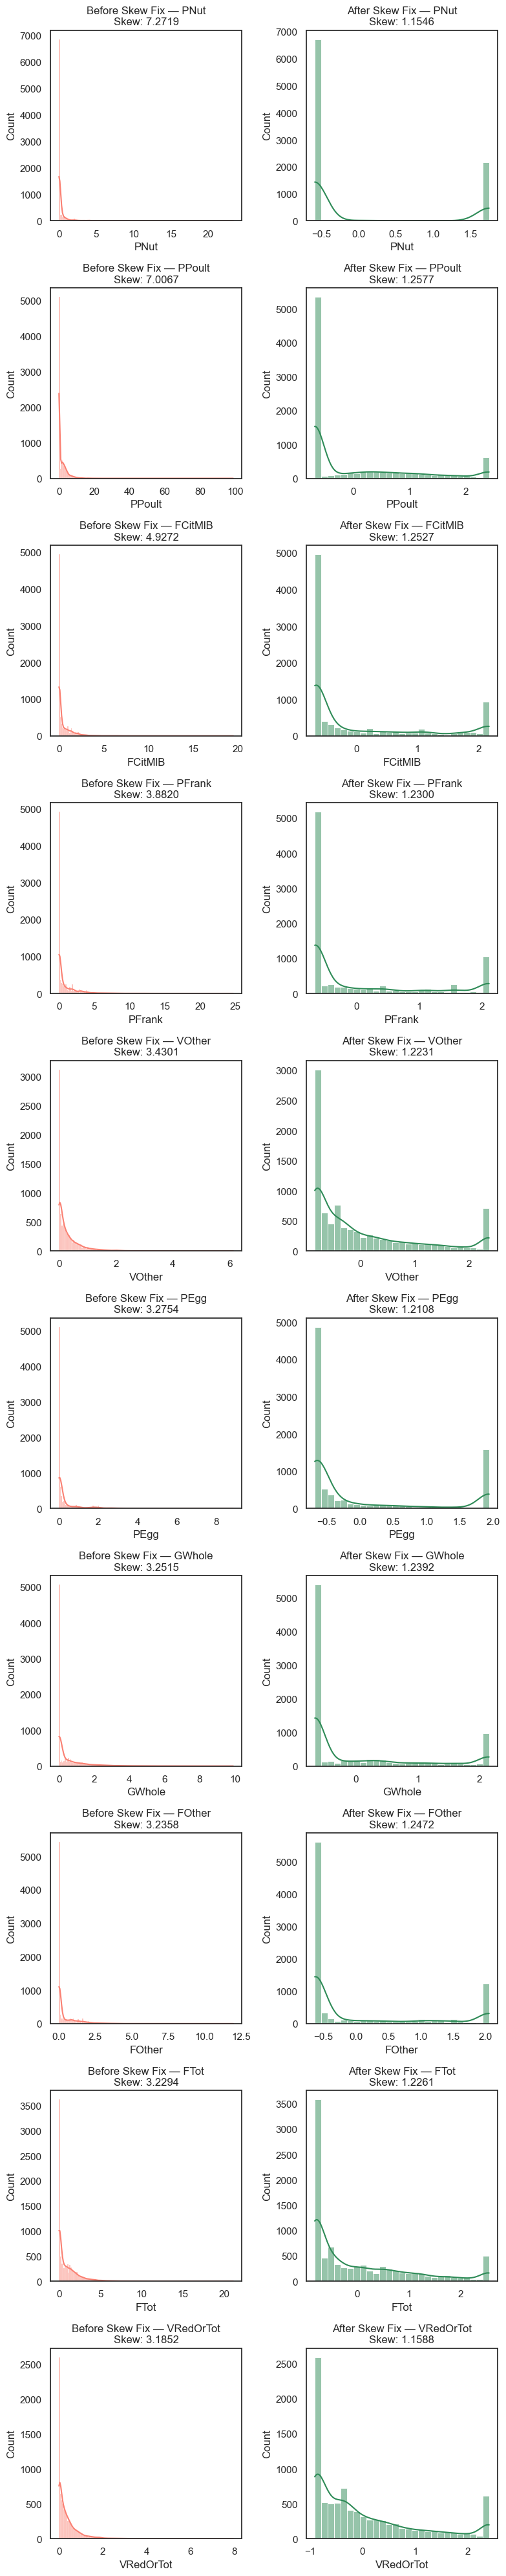

In [ ]:
# 1. Extract continuous features BEFORE transformation
X_train_cont_before = X_train[con_features].copy()

# 2. Extract continuous features AFTER transformation
# Only columns created from continuous__*
cont_after_cols = [c for c in X_train_non_tree_df.columns if c.startswith("continuous__")]
X_train_cont_after = X_train_non_tree_df[cont_after_cols].copy()

# Strip prefix for comparison later
X_train_cont_after.columns = [c.replace("continuous__", "") for c in cont_after_cols]

# Keep only columns that exist in both
common_continuous = [c for c in X_train_cont_after.columns if c in X_train_cont_before.columns]

X_train_cont_before = X_train_cont_before[common_continuous]
X_train_cont_after  = X_train_cont_after[common_continuous]

# 3. Compute skewness
skew_before = X_train_cont_before.skew()
skew_after  = X_train_cont_after.skew()

skew_summary = pd.DataFrame({
    "Skew_Before": skew_before,
    "Skew_After": skew_after
}).sort_values("Skew_Before", ascending=False)

with pd.option_context("display.float_format", "{:.4f}".format):
    display(skew_summary.head(10))

# 4. Plot BEFORE vs AFTER histograms
top_features = skew_summary.head(10).index.tolist()

plt.figure(figsize=(8, 4 * len(top_features)))

for i, col in enumerate(top_features):
    # Before fix
    plt.subplot(len(top_features), 2, 2*i + 1)
    sns.histplot(X_train_cont_before[col], kde=True, color="salmon")
    plt.title(f"Before Skew Fix — {col}\nSkew: {skew_before[col]:.4f}")

    # After fix
    plt.subplot(len(top_features), 2, 2*i + 2)
    sns.histplot(X_train_cont_after[col], kde=True, color="seagreen")
    plt.title(f"After Skew Fix — {col}\nSkew: {skew_after[col]:.4f}")



plt.tight_layout()
plt.show()


### Now the all data is preprocessed with 13% Yes. We need to handle this imblanced data.
Scikit-learn algorithms that support class_weight:
| **Algorithm**                                                                            | **Supports `class_weight`?** | **Parameter name** | **Notes**                                        |
| ---------------------------------------------------------------------------------------- | ---------------------------- | ------------------ | ------------------------------------------------ |
| **Logistic Regression**                                                                  | ✅ Yes                        | `class_weight`     | Works very well for moderate imbalance           |
| **Linear SVM (`LinearSVC`)**                                                             | ✅ Yes                        | `class_weight`     | Use `class_weight='balanced'` or pass dict       |
| **Kernel SVM (`SVC`)**                                                                   | ✅ Yes                        | `class_weight`     | Applies to all kernels (linear, rbf, etc.)       |
| **Decision Tree**                                                                        | ✅ Yes                        | `class_weight`     | Applies per sample split criterion               |
| **Random Forest**                                                                        | ✅ Yes                        | `class_weight`     | Helps trees pay more attention to minority class |
| **Gradient Boosting (sklearn)**                                                          | ⚠️ No direct support         | —                  | You can reweight samples manually                |
| **HistGradientBoostingClassifier**                                                       | ✅ Yes                        | `class_weight`     | Added in newer scikit-learn versions             |
| **LogisticRegressionCV**                                                                 | ✅ Yes                        | `class_weight`     | Works same as LogisticRegression                 |
| **RidgeClassifier**                                                                      | ✅ Yes                        | `class_weight`     | Linear classifier alternative                    |
| **Perceptron / SGDClassifier**                                                           | ✅ Yes                        | `class_weight`     | Useful for linear models trained via SGD         |
| **BalancedBaggingClassifier / BalancedRandomForestClassifier** *(from imbalanced-learn)* | ✅ Yes                        | —                  | Specifically designed for imbalance              |


* Algorithms that do NOT directly support class_weight
| Algorithm                         | Workaround                                                                                             |
| --------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **KNN (`KNeighborsClassifier`)**  | Doesn’t support `class_weight`; can oversample minority class before training                          |
| **Naive Bayes**                   | Doesn’t have built-in `class_weight`; you can weight samples manually using `sample_weight` in `fit()` |
| **XGBoost / LightGBM / CatBoost** | No `class_weight` parameter per se, but support equivalent parameters like `scale_pos_weight`          |

* Automatically balance classes
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)
* or manually
log_reg = LogisticRegression(class_weight={'No': 1, 'Yes': 6})
* If you use XGBoost, LightGBM, or CatBoost, here’s the equivalent:
| Library      | Parameter                                 | Meaning                                  |
| ------------ | ----------------------------------------- | ---------------------------------------- |
| **XGBoost**  | `scale_pos_weight`                        | Ratio of negative to positive samples    |
| **LightGBM** | `is_unbalance=True` or `scale_pos_weight` | Similar logic                            |
| **CatBoost** | `class_weights`                           | Accepts a list of weights for each class |

Once you’ve done the stratified split, you can handle imbalance only on the training data, never on test/validation.

### Feature selection: the best method for this project is the __hybrid__ method.

🔹 Step 1: Removing low-variance features...
Removed 1 low-variance features.
Remaining features after filtering: 102

🔹 Step 2: Ranking features using RandomForest importance...
Selected 65 features explaining 95.0% of total importance.

🔹 Step 4: L1 Logistic Regression refinement (optional)...
Refined down to 65 final features (non-zero L1 coefficients).

📊 Plotting top 20 feature importances...


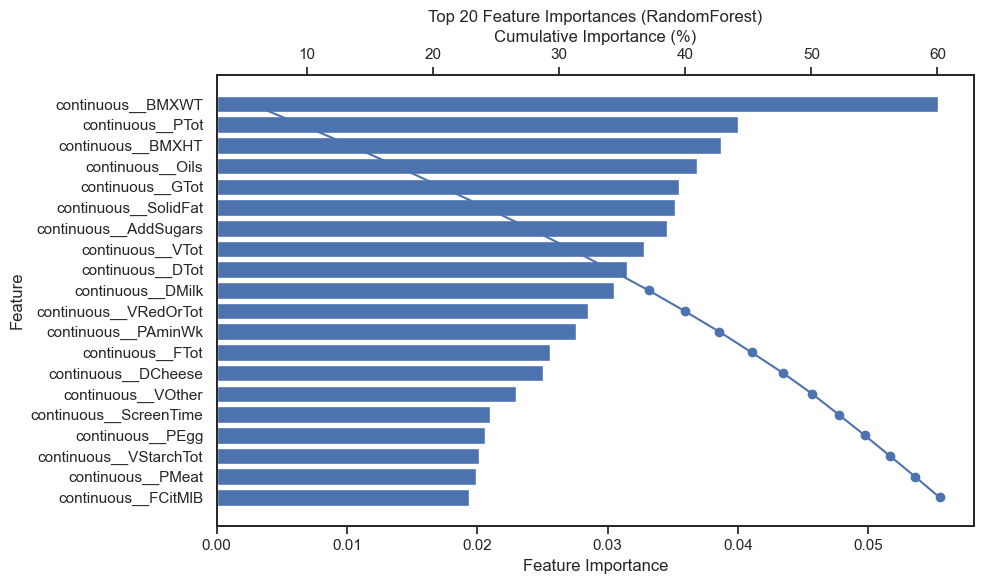


✅ Final Selected Features:
 1. continuous__BMXWT
 2. continuous__PTot
 3. continuous__BMXHT
 4. continuous__Oils
 5. continuous__GTot
 6. continuous__SolidFat
 7. continuous__AddSugars
 8. continuous__VTot
 9. continuous__DTot
10. continuous__DMilk
11. continuous__VRedOrTot
12. continuous__PAminWk
13. continuous__FTot
14. continuous__DCheese
15. continuous__VOther
16. continuous__ScreenTime
17. continuous__PEgg
18. continuous__VStarchTot
19. continuous__PMeat
20. continuous__FCitMlB
21. continuous__PFrank
22. continuous__GWhole
23. continuous__RIDAGEYR
24. continuous__PPoult
25. ordinal__BMIcat
26. continuous__HOD050
27. continuous__FOther
28. continuous__MealsOut
29. categorical__RIAGENDR_1.0
30. categorical__RIAGENDR_2.0
31. continuous__NwkLunch
32. ordinal__FamPIRCat
33. ordinal__FamIncC
34. ordinal__TimesHCLastYr
35. binary__FdStmp
36. categorical__RaceEth_1.0
37. continuous__NwkBkfast
38. categorical__RaceEth_2.0
39. ordinal__Milk30Days
40. ordinal__HHREdu
41. ordinal__HealthCond

In [ ]:
# HYBRID FEATURE SELECTION PIPELINE for NON-TREE MODELS
# Works on X_train_non_tree_df (already preprocessed), not raw data
# Steps:
#   1. Remove low-variance features
#   2. Rank features via RandomForest importance
#   3. Keep features explaining a chosen fraction of total importance
#   4. Refine with L1 Logistic Regression
#   5. Plot top 20 importances
#   6. Apply selected features to train / val / test

from sklearn.feature_selection import VarianceThreshold

# Configuration knobs for you to play with
CUM_IMPORTANCE_THRESHOLD = 0.95   # try 0.95 or 0.99
USE_L1_REFINEMENT        = True   # set to False to skip L1 refinement

# Step 1: Remove low-variance features
print("🔹 Step 1: Removing low-variance features...")

vt = VarianceThreshold(threshold=0.01)
vt.fit(X_train_non_tree_df)

low_var_features = X_train_non_tree_df.columns[~vt.get_support()]
print(f"Removed {len(low_var_features)} low-variance features.")

X_train_filt = X_train_non_tree_df.drop(columns=low_var_features)
print(f"Remaining features after filtering: {X_train_filt.shape[1]}")

# Step 2: RandomForest feature importances
print("\n🔹 Step 2: Ranking features using RandomForest importance...")

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_filt, y_train, sample_weight=w_train_norm)

importances = pd.Series(rf.feature_importances_, index=X_train_filt.columns)
importances = importances.sort_values(ascending=False)

# Step 3: Keep features explaining chosen fraction of total importance
cumulative_importance = importances.cumsum() / importances.sum()
selected_rf_features = cumulative_importance[cumulative_importance <= CUM_IMPORTANCE_THRESHOLD].index.tolist()

print(f"Selected {len(selected_rf_features)} features explaining {CUM_IMPORTANCE_THRESHOLD*100:.1f}% of total importance.")

# Step 4: L1 Logistic Regression refinement
if USE_L1_REFINEMENT:
    print("\nStep 4: L1 Logistic Regression refinement...")

    X_train_rf = X_train_filt[selected_rf_features].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train_rf)

    # Note: we already encode survey × class imbalance in w_train_final,
    # so we do NOT also use class_weight here (to avoid double-weighting).
    logr = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        max_iter=2000,
        random_state=42
    )
    logr.fit(X_scaled, y_train, sample_weight=w_train_norm)

    # Keep only features with non-zero coefficients
    coef_mask = (logr.coef_[0] != 0)
    selected_final = X_train_rf.columns[coef_mask].tolist()

    print(f"Refined down to {len(selected_final)} final features (non-zero L1 coefficients).")
else:
    print("\nStep 4: Skipping L1 refinement, using RF-selected set directly.")
    selected_final = list(selected_rf_features)

# Step 5: Plot top 20 importances
print("\nPlotting top 20 feature importances...")

top_n = 20
top_importances = importances.head(top_n)
cum_values = (top_importances.cumsum() / importances.sum()) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.barh(top_importances.index[::-1], top_importances.values[::-1])
ax1.set_xlabel("Feature Importance")
ax1.set_ylabel("Feature")
ax1.set_title(f"Top {top_n} Feature Importances (RandomForest)")

ax2 = ax1.twiny()
ax2.plot(cum_values.values[::-1], range(len(cum_values)), marker='o')
ax2.set_xlabel("Cumulative Importance (%)")

plt.tight_layout()
plt.show()

# Step 6: Apply selected subset to ALL non-tree splits
print("\nFinal Selected Features:")
for i, f in enumerate(selected_final, 1):
    print(f"{i:>2}. {f}")

X_train_non_tree_sel = X_train_non_tree_df[selected_final].copy()
X_val_non_tree_sel   = X_val_non_tree_df[selected_final].copy()
X_test_non_tree_sel  = X_test_non_tree_df[selected_final].copy()

print("\nFinal shapes (NON-TREE SELECTED FEATURES) - X_train_non_tree_sel:")
print(f"Train: {X_train_non_tree_sel.shape},  Val: {X_val_non_tree_sel.shape},  Test: {X_test_non_tree_sel.shape}")

print("Shapes after feature selection:")
print("X_train_non_tree_sel:", X_train_non_tree_sel.shape)
print("X_val_non_tree_sel:  ", X_val_non_tree_sel.shape)
print("X_test_non_tree_sel: ", X_test_non_tree_sel.shape)


**Summary - Non-tree based models Feature Selection Process: **   
| Step                           | Operation                                | Purpose                               |
| ------------------------------ | ---------------------------------------- | ------------------------------------- |
| **1️⃣ Low-variance filter**    | Drops constant / nearly constant columns | Removes uninformative variables       |
| **2️⃣ RandomForest ranking**   | Uses impurity-based importance           | Captures nonlinear effects            |
| **3️⃣ 95 % cumulative cutoff** | Keeps strongest predictors only          | Reduces redundancy                    |
| **4️⃣ L1 Logistic refinement** | Shrinks noisy features to zero           | Improves stability & interpretability |
| **5️⃣ Visualization**          | Bar + line plot for top 20 features      | Quick at-a-glance explanation         |
| **6️⃣ Final datasets**         | Returns clean feature subset             | Ready for Logistic / RF / DL models   |


In [ ]:
# FIT + SAFE PREDICT + UNIFIED EVAL
def fit(model, X, y, sample_weight=None):
    """Fits model while gracefully handling sample weights & pipeline models."""
    model_type = str(type(model))

    if hasattr(model, "steps"):
        last_step = model.steps[-1][0]
        if sample_weight is not None:
            return model.fit(X, y, **{f"{last_step}__sample_weight": sample_weight})
        else:
            return model.fit(X, y)

    try:
        return model.fit(X, y, sample_weight=sample_weight)
    except TypeError:
        return model.fit(X, y)


def predict_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        df = model.decision_function(X)
        return 1 / (1 + np.exp(-df))
    return model.predict(X).astype(float)


def eval_model_unified(model, name,
                       X_train, y_train, w_train_final,
                       X_val, y_val, w_val_norm):

    print(f"\nTraining: {name}")

    model = fit(model, X_train, y_train, sample_weight=w_train_final)

    yprob = predict_proba(model, X_val)
    ypred = (yprob >= 0.5).astype(int)

    metrics = {
        "Model": name,
        "roc_auc": roc_auc_score(y_val, yprob, sample_weight=w_val_norm),
        "f1_weighted": f1_score(y_val, ypred, average="weighted", sample_weight=w_val_norm),
        "recall_weighted": recall_score(y_val, ypred, average="weighted", sample_weight=w_val_norm),
        "precision_weighted": precision_score(y_val, ypred, average="weighted", sample_weight=w_val_norm)
    }
    return metrics, yprob, model


In [ ]:
# BUILD BASE MODELS
def build_models():
    models = {

        # Tree-based
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),

        "XGBoost": XGBClassifier(
            n_estimators=400, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric="auc", n_jobs=-1, tree_method="hist"
        ),

        "LightGBM": LGBMClassifier(
            n_estimators=400, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8
        ),

        "CatBoost": CatBoostClassifier(verbose=0, iterations=300, learning_rate=0.05, eval_metric="AUC"),

        # Non-tree
        "LogisticRegression_L2": LogisticRegression(penalty="l2", solver="liblinear", max_iter=2000),
        "LogisticRegression_L1": LogisticRegression(penalty="l1", solver="liblinear", max_iter=2000),
        "RidgeClassifier": RidgeClassifier(),

        "SVM_Linear": SVC(kernel="linear", probability=True),

        "LogisticRegression_Poly2": Pipeline([
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("logr", LogisticRegression(max_iter=3000))
        ]),

        "SGDClassifier": SGDClassifier(loss="log_loss", max_iter=2000, tol=1e-3),

        "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", solver="adam", max_iter=300),
    }

    return models


In [ ]:
# GRIDSEARCH PARAM GRIDS (Non-tree models only)
def get_param_grids():
    return {
        "LogisticRegression_L2": {"C": [0.01, 0.1, 1.0, 10.0]},
        "LogisticRegression_L1": {"C": [0.01, 0.1, 1.0, 10.0]},
        "RidgeClassifier": {"alpha": [0.1, 1.0, 10.0]},
        "SVM_Linear": {"C": [0.1, 1.0, 10.0]},
        "LogisticRegression_Poly2": {"logr__C": [0.01, 0.1, 1.0]},
        "SGDClassifier": {"alpha": [1e-5, 1e-4, 1e-3], "penalty": ["l2", "l1", "elasticnet"]},
        "MLP": {"hidden_layer_sizes": [(64, 32), (128, 64)], "alpha": [1e-5, 1e-4]},
    }


In [ ]:
# OPTUNA SEARCH SPACE (Tree models)
def suggest_params_optuna(trial, name):

    if name == "RandomForest":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 200, 600, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        }

    if name == "GradientBoosting":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }


    if name == "AdaBoost":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 50, 400, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        }

    if name == "XGBoost":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 200, 600, step=100),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        }

    if name == "LightGBM":
        return {
            "n_estimators": trial.suggest_int("n_estimators", 200, 600, step=100),
            "num_leaves": trial.suggest_int("num_leaves", 16, 64),
        }

    if name == "CatBoost":
        return {
            "iterations": trial.suggest_int("iterations", 200, 600, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
        }

    return {}


In [ ]:
# GRIDSEARCH TUNER (Non-tree models)
def grid_search_tune(name, base_model, param_grid,
                     X_train, y_train, w_train_final,
                     X_val, y_val, w_val_norm):

    best_score = -np.inf
    best_params = None
    best_model = None
    best_metrics = None

    for params in ParameterGrid(param_grid):
        model = clone(base_model)
        model.set_params(**params)

        metrics, _, fitted = eval_model_unified(
            model, name,
            X_train, y_train, w_train_final,
            X_val, y_val, w_val_norm
        )

        if metrics["roc_auc"] > best_score:
            best_score = metrics["roc_auc"]
            best_params = params
            best_model = fitted
            best_metrics = metrics

    return best_model, best_metrics, best_params


In [ ]:
# OPTUNA TUNER (Tree models)
def optuna_tune(name, base_model,
                X_train, y_train, w_train_final,
                X_val, y_val, w_val_norm,
                n_trials=20, timeout=None):

    def objective(trial):
        params = suggest_params_optuna(trial, name)

        model = clone(base_model)
        model.set_params(**params)

        metrics, _, _ = eval_model_unified(
            model, name,
            X_train, y_train, w_train_final,
            X_val, y_val, w_val_norm
        )

        return metrics["roc_auc"]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    best_params = study.best_params

    # Build final fitted model based on best params
    best_model = clone(base_model)
    best_model.set_params(**best_params)

    best_metrics, _, best_model = eval_model_unified(
        best_model, name,
        X_train, y_train, w_train_final,
        X_val, y_val, w_val_norm
    )

    return best_model, best_metrics, best_params



In [ ]:
# RUN TREE-BASED TUNING
def run_tree_models_tuned(
    X_train_tree_df, y_train, w_train_final,
    X_val_tree_df, y_val, w_val_norm,
    n_trials_optuna=20
):

    tree_model_names = [
        "RandomForest", "GradientBoosting",
        "AdaBoost", "XGBoost", "LightGBM", "CatBoost"
    ]

    models = build_models()
    results = []
    best_models = {}
    best_params = {}

    for name in tree_model_names:
        model = models[name]
        print(f"\n================ TREE MODEL: {name} ================")

        tuned_model, metrics, params = optuna_tune(
            name, model,
            X_train_tree_df, y_train, w_train_final,
            X_val_tree_df, y_val, w_val_norm,
            n_trials=n_trials_optuna
        )

        results.append(metrics)
        best_models[name] = tuned_model
        best_params[name] = params

    results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False)
    return results_df, best_models, best_params


In [ ]:
# RUN NON-TREE TUNING
def run_non_tree_models_tuned(
    X_train_non_tree_sel, y_train, w_train_final,
    X_val_non_tree_sel, y_val, w_val_norm
):

    param_grids = get_param_grids()
    models = build_models()

    results = []
    best_models = {}
    best_params = {}

    for name, grid in param_grids.items():
        model = models[name]
        print(f"\n=========== NON-TREE MODEL: {name} ===========")

        tuned_model, metrics, params = grid_search_tune(
            name, model, grid,
            X_train_non_tree_sel, y_train, w_train_final,
            X_val_non_tree_sel, y_val, w_val_norm
        )

        results.append(metrics)
        best_models[name] = tuned_model
        best_params[name] = params

    results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False)
    return results_df, best_models, best_params


In [ ]:
# SELECT TOP MODELS FOR ENSEMBLES
def select_top_models(results_df, best_models, top_n=5):
    top_names = results_df.head(top_n)["Model"].tolist()
    top_models = {name: best_models[name] for name in top_names}
    return top_names, top_models


In [ ]:
# Run Tree-based tuning
results_tree, best_tree_models, best_tree_params = run_tree_models_tuned(
    X_train_tree_df, y_train, w_train_final,
    X_val_tree_df, y_val, w_val_norm,
    n_trials_optuna=10
)

[I 2026-01-16 17:30:20,297] A new study created in memory with name: no-name-94ee412a-6ea8-4ea3-9d69-c502bc8fb347



================ TREE MODEL: RandomForest ================

🧠 Training: RandomForest


[I 2026-01-16 17:30:21,208] Trial 0 finished with value: 0.6743288681737879 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:22,381] Trial 1 finished with value: 0.6648474423038779 and parameters: {'n_estimators': 300, 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:24,268] Trial 2 finished with value: 0.661434233646438 and parameters: {'n_estimators': 400, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:26,238] Trial 3 finished with value: 0.6709913138374519 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:27,039] Trial 4 finished with value: 0.6721130580413581 and parameters: {'n_estimators': 300, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:29,577] Trial 5 finished with value: 0.6740945447602803 and parameters: {'n_estimators': 600, 'max_depth': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:31,332] Trial 6 finished with value: 0.670440455107555 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:32,603] Trial 7 finished with value: 0.6724031239620745 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6743288681737879.



🧠 Training: RandomForest


[I 2026-01-16 17:30:33,735] Trial 8 finished with value: 0.6750502860420718 and parameters: {'n_estimators': 400, 'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.6750502860420718.



🧠 Training: RandomForest


[I 2026-01-16 17:30:36,480] Trial 9 finished with value: 0.6705169551704886 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 8 with value: 0.6750502860420718.



🧠 Training: RandomForest


[I 2026-01-16 17:30:37,621] A new study created in memory with name: no-name-25cb6200-c8e3-4de2-a28b-c13425c4c434



================ TREE MODEL: GradientBoosting ================

🧠 Training: GradientBoosting


[I 2026-01-16 17:30:58,228] Trial 0 finished with value: 0.664782794228401 and parameters: {'n_estimators': 350, 'learning_rate': 0.027691253683268063, 'max_depth': 3}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:31:16,173] Trial 1 finished with value: 0.6445463826509646 and parameters: {'n_estimators': 150, 'learning_rate': 0.10192965477578537, 'max_depth': 6}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:31:25,952] Trial 2 finished with value: 0.660895686402359 and parameters: {'n_estimators': 250, 'learning_rate': 0.06932917269926706, 'max_depth': 2}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:31:31,815] Trial 3 finished with value: 0.6584886132699854 and parameters: {'n_estimators': 150, 'learning_rate': 0.19544087181630523, 'max_depth': 2}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:31:56,644] Trial 4 finished with value: 0.6319153328315694 and parameters: {'n_estimators': 250, 'learning_rate': 0.16234422175077678, 'max_depth': 5}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:32:14,427] Trial 5 finished with value: 0.6371722887661289 and parameters: {'n_estimators': 150, 'learning_rate': 0.1250038264043417, 'max_depth': 6}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:32:20,347] Trial 6 finished with value: 0.6618891486910963 and parameters: {'n_estimators': 150, 'learning_rate': 0.15208719741651094, 'max_depth': 2}. Best is trial 0 with value: 0.664782794228401.



🧠 Training: GradientBoosting


[I 2026-01-16 17:32:28,275] Trial 7 finished with value: 0.6687526692509995 and parameters: {'n_estimators': 200, 'learning_rate': 0.024581613634892672, 'max_depth': 2}. Best is trial 7 with value: 0.6687526692509995.



🧠 Training: GradientBoosting


[I 2026-01-16 17:32:36,082] Trial 8 finished with value: 0.6632691971818455 and parameters: {'n_estimators': 100, 'learning_rate': 0.06642373338244109, 'max_depth': 4}. Best is trial 7 with value: 0.6687526692509995.



🧠 Training: GradientBoosting


[I 2026-01-16 17:32:56,575] Trial 9 finished with value: 0.6614723741002174 and parameters: {'n_estimators': 350, 'learning_rate': 0.0475474280870751, 'max_depth': 3}. Best is trial 7 with value: 0.6687526692509995.



🧠 Training: GradientBoosting


[I 2026-01-16 17:33:04,545] A new study created in memory with name: no-name-76393a51-3c8e-4eca-a736-db4318d15a92



================ TREE MODEL: AdaBoost ================

🧠 Training: AdaBoost


[I 2026-01-16 17:33:10,030] Trial 0 finished with value: 0.6680632221147473 and parameters: {'n_estimators': 200, 'learning_rate': 0.19768381273103613}. Best is trial 0 with value: 0.6680632221147473.



🧠 Training: AdaBoost


[I 2026-01-16 17:33:15,465] Trial 1 finished with value: 0.6595141400782553 and parameters: {'n_estimators': 200, 'learning_rate': 0.04141513465719449}. Best is trial 0 with value: 0.6680632221147473.



🧠 Training: AdaBoost


[I 2026-01-16 17:33:18,167] Trial 2 finished with value: 0.6334005897100532 and parameters: {'n_estimators': 100, 'learning_rate': 0.01044745739168659}. Best is trial 0 with value: 0.6680632221147473.



🧠 Training: AdaBoost


[I 2026-01-16 17:33:26,396] Trial 3 finished with value: 0.6650932493586361 and parameters: {'n_estimators': 300, 'learning_rate': 0.040053215489176244}. Best is trial 0 with value: 0.6680632221147473.



🧠 Training: AdaBoost


[I 2026-01-16 17:33:37,192] Trial 4 finished with value: 0.6651696077811062 and parameters: {'n_estimators': 400, 'learning_rate': 0.041822381737800396}. Best is trial 0 with value: 0.6680632221147473.



🧠 Training: AdaBoost


[I 2026-01-16 17:33:48,140] Trial 5 finished with value: 0.6741653700734431 and parameters: {'n_estimators': 400, 'learning_rate': 0.4315423996084865}. Best is trial 5 with value: 0.6741653700734431.



🧠 Training: AdaBoost


[I 2026-01-16 17:33:49,542] Trial 6 finished with value: 0.6418562237661616 and parameters: {'n_estimators': 50, 'learning_rate': 0.08606944451472633}. Best is trial 5 with value: 0.6741653700734431.



🧠 Training: AdaBoost


[I 2026-01-16 17:34:00,883] Trial 7 finished with value: 0.6660026406977817 and parameters: {'n_estimators': 400, 'learning_rate': 0.06038744101179946}. Best is trial 5 with value: 0.6741653700734431.



🧠 Training: AdaBoost


[I 2026-01-16 17:34:02,362] Trial 8 finished with value: 0.6146793886496915 and parameters: {'n_estimators': 50, 'learning_rate': 0.01596745866221014}. Best is trial 5 with value: 0.6741653700734431.



🧠 Training: AdaBoost


[I 2026-01-16 17:34:03,723] Trial 9 finished with value: 0.6337106787217732 and parameters: {'n_estimators': 50, 'learning_rate': 0.025983349623421}. Best is trial 5 with value: 0.6741653700734431.



🧠 Training: AdaBoost


[I 2026-01-16 17:34:14,619] A new study created in memory with name: no-name-2d9835d8-82d4-41f7-b975-2dab53341dd8



================ TREE MODEL: XGBoost ================

🧠 Training: XGBoost


[I 2026-01-16 17:34:14,999] Trial 0 finished with value: 0.6573276784218756 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1293271751856965}. Best is trial 0 with value: 0.6573276784218756.



🧠 Training: XGBoost


[I 2026-01-16 17:34:16,952] Trial 1 finished with value: 0.6615381335811263 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05312930038422996}. Best is trial 1 with value: 0.6615381335811263.



🧠 Training: XGBoost


[I 2026-01-16 17:34:18,276] Trial 2 finished with value: 0.6650707982340534 and parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.013132173616187712}. Best is trial 2 with value: 0.6650707982340534.



🧠 Training: XGBoost


[I 2026-01-16 17:34:19,776] Trial 3 finished with value: 0.6543249684476374 and parameters: {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.14768273780960342}. Best is trial 2 with value: 0.6650707982340534.



🧠 Training: XGBoost


[I 2026-01-16 17:34:22,014] Trial 4 finished with value: 0.6567569411599525 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.18558609174328103}. Best is trial 2 with value: 0.6650707982340534.



🧠 Training: XGBoost


[I 2026-01-16 17:34:23,536] Trial 5 finished with value: 0.6581114342443786 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.10596124654555276}. Best is trial 2 with value: 0.6650707982340534.



🧠 Training: XGBoost


[I 2026-01-16 17:34:25,309] Trial 6 finished with value: 0.6665781225616898 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05037898936543281}. Best is trial 6 with value: 0.6665781225616898.



🧠 Training: XGBoost


[I 2026-01-16 17:34:27,739] Trial 7 finished with value: 0.6528944257831493 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.0871989224691917}. Best is trial 6 with value: 0.6665781225616898.



🧠 Training: XGBoost


[I 2026-01-16 17:34:28,477] Trial 8 finished with value: 0.6797576551469249 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.013984294202959907}. Best is trial 8 with value: 0.6797576551469249.



🧠 Training: XGBoost


[I 2026-01-16 17:34:29,343] Trial 9 finished with value: 0.6636950253448375 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.0695654770129809}. Best is trial 8 with value: 0.6797576551469249.



🧠 Training: XGBoost


[I 2026-01-16 17:34:30,097] A new study created in memory with name: no-name-c5075d64-98aa-4a8c-b298-be2f0e791ffc



================ TREE MODEL: LightGBM ================

🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:30,990] Trial 0 finished with value: 0.6664670407350052 and parameters: {'n_estimators': 400, 'num_leaves': 52}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:31,574] Trial 1 finished with value: 0.655521394119444 and parameters: {'n_estimators': 400, 'num_leaves': 30}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:32,187] Trial 2 finished with value: 0.6478587171084047 and parameters: {'n_estimators': 300, 'num_leaves': 45}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:33,438] Trial 3 finished with value: 0.6552155250140852 and parameters: {'n_estimators': 500, 'num_leaves': 63}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:34,751] Trial 4 finished with value: 0.660323213053054 and parameters: {'n_estimators': 600, 'num_leaves': 53}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:35,957] Trial 5 finished with value: 0.6648273881494531 and parameters: {'n_estimators': 600, 'num_leaves': 48}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:36,865] Trial 6 finished with value: 0.6621810775791506 and parameters: {'n_estimators': 500, 'num_leaves': 40}. Best is trial 0 with value: 0.6664670407350052.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:37,201] Trial 7 finished with value: 0.6668400851960417 and parameters: {'n_estimators': 300, 'num_leaves': 19}. Best is trial 7 with value: 0.6668400851960417.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:37,834] Trial 8 finished with value: 0.6524492264319235 and parameters: {'n_estimators': 300, 'num_leaves': 47}. Best is trial 7 with value: 0.6668400851960417.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:38,730] Trial 9 finished with value: 0.6471467022935136 and parameters: {'n_estimators': 500, 'num_leaves': 39}. Best is trial 7 with value: 0.6668400851960417.



🧠 Training: LightGBM
[LightGBM] [Info] Number of positive: 1206, number of negative: 7883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7662
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491686 -> initscore=-0.033259
[LightGBM] [Info] Start training from score -0.033259


[I 2026-01-16 17:34:39,080] A new study created in memory with name: no-name-1673b547-7f28-4f14-bb5f-fe4ca07c409b



================ TREE MODEL: CatBoost ================

🧠 Training: CatBoost


[I 2026-01-16 17:34:42,047] Trial 0 finished with value: 0.6478252207505099 and parameters: {'iterations': 500, 'learning_rate': 0.04813708622420674, 'depth': 5}. Best is trial 0 with value: 0.6478252207505099.



🧠 Training: CatBoost


[I 2026-01-16 17:35:43,004] Trial 1 finished with value: 0.6526960731529681 and parameters: {'iterations': 600, 'learning_rate': 0.1342401219385407, 'depth': 10}. Best is trial 1 with value: 0.6526960731529681.



🧠 Training: CatBoost


[I 2026-01-16 17:36:05,601] Trial 2 finished with value: 0.660714705599758 and parameters: {'iterations': 600, 'learning_rate': 0.022907118219577725, 'depth': 9}. Best is trial 2 with value: 0.660714705599758.



🧠 Training: CatBoost


[I 2026-01-16 17:36:07,149] Trial 3 finished with value: 0.6758566247637828 and parameters: {'iterations': 300, 'learning_rate': 0.07441829173775692, 'depth': 4}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


[I 2026-01-16 17:36:09,466] Trial 4 finished with value: 0.623380427491842 and parameters: {'iterations': 200, 'learning_rate': 0.12230903220129648, 'depth': 7}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


[I 2026-01-16 17:36:27,202] Trial 5 finished with value: 0.6606664105618262 and parameters: {'iterations': 500, 'learning_rate': 0.022029865286108865, 'depth': 9}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


[I 2026-01-16 17:36:47,937] Trial 6 finished with value: 0.6420452136624142 and parameters: {'iterations': 200, 'learning_rate': 0.06303653528193681, 'depth': 10}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


[I 2026-01-16 17:36:52,410] Trial 7 finished with value: 0.6482377310599902 and parameters: {'iterations': 400, 'learning_rate': 0.18110619181856746, 'depth': 7}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


[I 2026-01-16 17:36:54,342] Trial 8 finished with value: 0.6734520844047103 and parameters: {'iterations': 400, 'learning_rate': 0.021300816627640846, 'depth': 4}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


[I 2026-01-16 17:37:08,466] Trial 9 finished with value: 0.6679383712448058 and parameters: {'iterations': 400, 'learning_rate': 0.015163065692512906, 'depth': 9}. Best is trial 3 with value: 0.6758566247637828.



🧠 Training: CatBoost


In [ ]:
# Run Non-tree tuning
results_non_tree, best_non_tree_models, best_non_tree_params = run_non_tree_models_tuned(
    X_train_non_tree_sel, y_train, w_train_final,
    X_val_non_tree_sel, y_val, w_val_norm
)


=========== NON-TREE MODEL: LogisticRegression_L2 ===========

🧠 Training: LogisticRegression_L2

🧠 Training: LogisticRegression_L2

🧠 Training: LogisticRegression_L2

🧠 Training: LogisticRegression_L2

=========== NON-TREE MODEL: LogisticRegression_L1 ===========

🧠 Training: LogisticRegression_L1

🧠 Training: LogisticRegression_L1

🧠 Training: LogisticRegression_L1

🧠 Training: LogisticRegression_L1

=========== NON-TREE MODEL: RidgeClassifier ===========

🧠 Training: RidgeClassifier

🧠 Training: RidgeClassifier

🧠 Training: RidgeClassifier

=========== NON-TREE MODEL: SVM_Linear ===========

🧠 Training: SVM_Linear

🧠 Training: SVM_Linear

🧠 Training: SVM_Linear

=========== NON-TREE MODEL: LogisticRegression_Poly2 ===========

🧠 Training: LogisticRegression_Poly2

🧠 Training: LogisticRegression_Poly2

🧠 Training: LogisticRegression_Poly2

=========== NON-TREE MODEL: SGDClassifier ===========

🧠 Training: SGDClassifier

🧠 Training: SGDClassifier

🧠 Training: SGDClassifier

🧠 Trainin

In [ ]:
# Combine results
results_combined = pd.concat([results_tree, results_non_tree]).sort_values("roc_auc", ascending=False)
best_all_models = {**best_tree_models, **best_non_tree_models}
display(results_combined)

,Model,roc_auc,f1_weighted,recall_weighted,precision_weighted
1,LogisticRegression_L1,0.68,0.71,0.66,0.83
3,XGBoost,0.68,0.76,0.72,0.82
0,LogisticRegression_L2,0.68,0.71,0.66,0.82
5,SGDClassifier,0.68,0.73,0.68,0.81
3,SVM_Linear,0.68,0.81,0.87,0.75
5,CatBoost,0.68,0.78,0.76,0.82
0,RandomForest,0.68,0.76,0.73,0.82
2,AdaBoost,0.67,0.73,0.68,0.82
2,RidgeClassifier,0.67,0.71,0.65,0.82
1,GradientBoosting,0.67,0.74,0.69,0.82


In [ ]:
# Select top 5 models
top_names, top_models = select_top_models(results_combined, best_all_models, top_n=5)

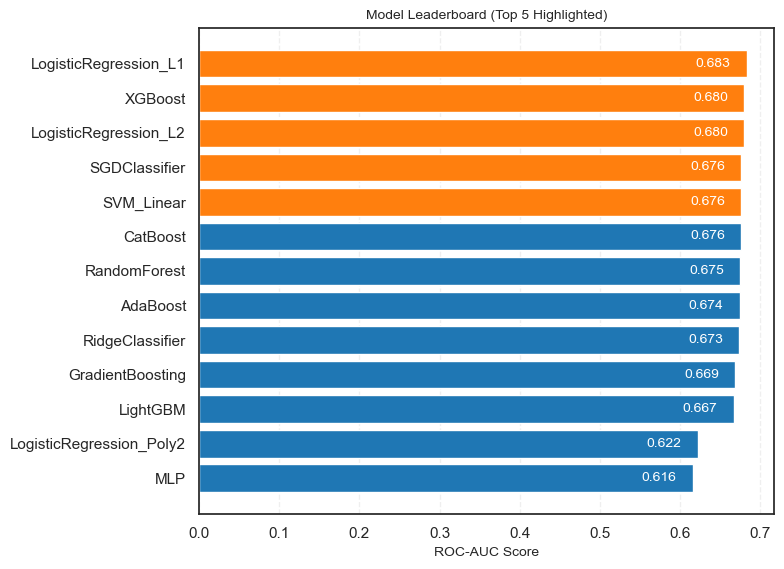

In [ ]:
def plot_leaderboard(results_df, top_n=5):
    # Sort by ROC-AUC
    df = results_df.sort_values("roc_auc", ascending=True)

    # Identify top N
    top_models = df.tail(top_n)["Model"].tolist()
    df["color"] = df["Model"].apply(lambda x: "#ff7f0e" if x in top_models else "#1f77b4")

    plt.figure(figsize=(8, 0.45 * len(df)))

    bars = plt.barh(df["Model"], df["roc_auc"], color=df["color"])

    plt.xlabel("ROC-AUC Score", fontsize=10)
    plt.title(f"Model Leaderboard (Top {top_n} Highlighted)", fontsize=10)
    plt.grid(axis="x", linestyle="--", alpha=0.3)

    for bar, (_, row) in zip(bars, df.iterrows()):
        width = bar.get_width()
        y = bar.get_y() + bar.get_height()/2

        # If bar is long, put text inside; otherwise to the right
        if width > 0.25:
            plt.text(width - 0.02, y, f"{row['roc_auc']:.3f}",
                     va="center", ha="right", color="white", fontsize=10)
        else:
            plt.text(width + 0.01, y, f"{row['roc_auc']:.3f}",
                     va="center", ha="left", fontsize=10)

    plt.tight_layout()
    plt.show()

# Run the leaderboard plot
plot_leaderboard(results_combined, top_n=5)

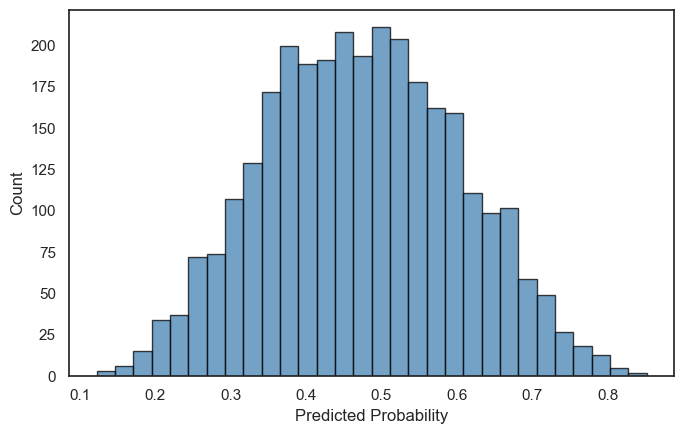

In [ ]:
# Retrieve fitted LogisticRegression_L1 model from previous cell
LogisticRegression_L1 = best_all_models["LogisticRegression_L1"]

# Predicted probabilities on validation set
val_proba = LogisticRegression_L1.predict_proba(X_val_non_tree_sel)[:, 1]

# Plot
plt.figure(figsize=(7, 4.5))
plt.hist(val_proba, bins=30, color="steelblue", edgecolor="black", alpha=0.75)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# CONFIG: set your probability cutoff threshold
THRESHOLD = 0.50   # e.g., 0.35 for higher recall, 0.60 for higher precision

# 1) Pick the best non-tree model (by ROC-AUC)
results_sorted = results_non_tree.sort_values("roc_auc", ascending=False)

model_keys = set(best_non_tree_models.keys())

# Auto-detect which column in results_non_tree holds the model names
candidate_cols = []
for c in results_sorted.columns:
    if results_sorted[c].dtype == "object" or pd.api.types.is_string_dtype(results_sorted[c]):
        overlap = set(results_sorted[c].dropna().astype(str).unique()) & set(map(str, model_keys))
        if len(overlap) > 0:
            candidate_cols.append((c, len(overlap)))

if not candidate_cols:
    raise KeyError(
        "Couldn't find a model-name column in results_non_tree that matches best_non_tree_models keys.\n"
        "Try: display(results_non_tree.head()) and print(best_non_tree_models.keys())"
    )

# Choose the column with the largest overlap with model keys
model_col = sorted(candidate_cols, key=lambda x: x[1], reverse=True)[0][0]

# Best model name from the top ROC-AUC row
best_model_name = results_sorted.iloc[0][model_col]
best_model = best_non_tree_models[best_model_name]

# 2) Predict probabilities on validation set
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_val_non_tree_sel)[:, 1]
else:
    # Fallback (rare): decision_function -> logistic squashing
    scores = best_model.decision_function(X_val_non_tree_sel)
    y_proba = 1 / (1 + np.exp(-scores))

# 3) Build output table: all features + probability + configurable class
predictions_df = X_val_non_tree_sel.copy()
predictions_df["predicted_probability"] = y_proba
predictions_df["predicted_class"] = (predictions_df["predicted_probability"] >= THRESHOLD).astype(int)

# include true labels for validation set debugging
# predictions_df["y_true"] = y_val.values

display(predictions_df.head(3))
print(f"Best non-tree model used: {best_model_name} (from column '{model_col}')")
print(f"Threshold used: {THRESHOLD}")


,continuous__BMXWT,continuous__PTot,continuous__BMXHT,continuous__Oils,continuous__GTot,continuous__SolidFat,continuous__AddSugars,continuous__VTot,continuous__DTot,continuous__DMilk,continuous__VRedOrTot,continuous__PAminWk,continuous__FTot,continuous__DCheese,continuous__VOther,continuous__ScreenTime,continuous__PEgg,continuous__VStarchTot,continuous__PMeat,continuous__FCitMlB,continuous__PFrank,continuous__GWhole,continuous__RIDAGEYR,continuous__PPoult,ordinal__BMIcat,continuous__HOD050,continuous__FOther,continuous__MealsOut,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,continuous__NwkLunch,ordinal__FamPIRCat,ordinal__FamIncC,ordinal__TimesHCLastYr,binary__FdStmp,categorical__RaceEth_1.0,continuous__NwkBkfast,categorical__RaceEth_2.0,ordinal__Milk30Days,ordinal__HHREdu,ordinal__HealthCond,ordinal__HHSizCat,ordinal__EducGrp,ordinal__FdInHH,ordinal__FdInAD,categorical__MilkType_3.0,categorical__HIns4_0.0,binary__HTChol,binary__hypten,categorical__DMDHRGND_1.0,categorical__DMDHRGND_0.0,categorical__HOQ065_1.0,ordinal__HHRAge,ordinal__AccScore,continuous__PNut,categorical__MilkType_4.0,categorical__HOQ065_0.0,categorical__HIns4_2.0,categorical__HUQ020_1.0,categorical__SchBkfst_1.0,categorical__RaceEth_0.0,binary__HHSmk,binary__Hager2Q,categorical__TypeHCplace_0.0,binary__Rx30Days,predicted_probability,predicted_class
0,-1.12,-1.11,-0.74,-0.83,-0.94,-0.97,-1.08,-0.87,-0.84,-0.36,-0.17,-0.95,-0.01,-0.90,-0.56,0.59,-0.50,-0.77,-0.74,-0.68,-0.67,1.72,-0.65,-0.68,1.00,-1.07,1.14,-1.18,0.00,1.00,1.02,1.00,2.00,3.00,0.00,0.00,2.02,1.00,2.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,2.00,0.00,1.75,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.57,1
1,-1.40,2.37,-0.32,0.52,0.78,2.48,2.51,2.49,2.49,2.55,2.41,-0.14,-0.81,0.99,2.37,1.22,-0.61,2.44,2.42,-0.68,-0.67,2.16,-1.09,-0.68,0.00,0.49,-0.63,-0.14,1.00,0.00,1.02,0.00,0.00,1.00,1.00,1.00,2.02,0.00,3.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,5.00,-0.58,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.26,0
2,-0.54,-0.53,-0.97,-0.52,-0.81,-1.22,-1.51,0.44,-1.22,-0.90,2.41,1.00,-0.81,-0.90,-0.84,0.27,-0.67,-0.77,1.35,-0.68,-0.67,-0.67,0.67,-0.68,1.00,-0.03,-0.63,1.94,0.00,1.00,-1.18,0.00,0.00,3.00,1.00,0.00,-0.57,0.00,0.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,2.00,5.00,-0.58,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.38,0


Best non-tree model used: LogisticRegression_L1 (from column 'Model')
Threshold used: 0.5


In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, balanced_accuracy_score
)

threshold_grid = np.linspace(0.01, 0.99, 99)

rows = []
for t in threshold_grid:
    y_pred = (y_proba >= t).astype(int)

    rows.append({
        "threshold": t,
        "balanced_accuracy": balanced_accuracy_score(y_val, y_pred),
        "f1_weighted": f1_score(y_val, y_pred, average="weighted", zero_division=0),
        "precision_weighted": precision_score(y_val, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_val, y_pred, average="weighted", zero_division=0),
        "f1_pos": f1_score(y_val, y_pred, average="binary", zero_division=0),
    })

threshold_results = pd.DataFrame(rows)

best_row = threshold_results.sort_values(
    ["balanced_accuracy", "f1_weighted"], ascending=False
).iloc[0]

THRESHOLD_OPT = float(best_row["threshold"])

print("Optimal threshold (validation):", THRESHOLD_OPT)
display(best_row.to_frame("best_value"))

display(threshold_results.sort_values("balanced_accuracy", ascending=False).head(10))

Optimal threshold (validation): 0.53


,best_value
threshold,0.53
balanced_accuracy,0.63
f1_weighted,0.73
precision_weighted,0.82
recall_weighted,0.68
f1_pos,0.32


,threshold,balanced_accuracy,f1_weighted,precision_weighted,recall_weighted,f1_pos
52,0.53,0.63,0.73,0.82,0.68,0.32
50,0.51,0.63,0.70,0.82,0.64,0.31
49,0.50,0.63,0.68,0.82,0.62,0.31
51,0.52,0.63,0.71,0.82,0.66,0.31
53,0.54,0.63,0.74,0.82,0.70,0.32
48,0.49,0.62,0.66,0.82,0.59,0.30
54,0.55,0.62,0.75,0.82,0.71,0.31
47,0.48,0.62,0.63,0.82,0.56,0.30
45,0.46,0.62,0.60,0.83,0.53,0.29
55,0.56,0.62,0.76,0.81,0.73,0.31


In [ ]:
# export feature importance

# Ensure we are working with the best model already selected earlier
model = best_model

# Safety check
if not hasattr(model, "coef_"):
    raise TypeError("Selected model does not expose coefficients (coef_).")

# Build feature-importance table
feature_importance_df = pd.DataFrame({
    "feature": X_val_non_tree_sel.columns,
    "coefficient": model.coef_[0]
})

feature_importance_df["abs_importance"] = feature_importance_df["coefficient"].abs()

# Sort from large → small
feature_importance_df = feature_importance_df.sort_values(
    "abs_importance", ascending=False
)

feature_importance_df.head(3)

FEATURE_IMPORTANCE_PATH = f"non_tree_{best_model_name}_feature_importance.csv"

feature_importance_df.to_csv(FEATURE_IMPORTANCE_PATH, index=False)

FEATURE_IMPORTANCE_PATH

'non_tree_LogisticRegression_L1_feature_importance.csv'

,continuous__BMXWT,continuous__PTot,continuous__BMXHT,continuous__Oils,continuous__GTot,continuous__SolidFat,continuous__AddSugars,continuous__VTot,continuous__DTot,continuous__DMilk,continuous__VRedOrTot,continuous__PAminWk,continuous__FTot,continuous__DCheese,continuous__VOther,continuous__ScreenTime,continuous__PEgg,continuous__VStarchTot,continuous__PMeat,continuous__FCitMlB,continuous__PFrank,continuous__GWhole,continuous__RIDAGEYR,continuous__PPoult,ordinal__BMIcat,continuous__HOD050,continuous__FOther,continuous__MealsOut,categorical__RIAGENDR_1.0,categorical__RIAGENDR_2.0,continuous__NwkLunch,ordinal__FamPIRCat,ordinal__FamIncC,ordinal__TimesHCLastYr,binary__FdStmp,categorical__RaceEth_1.0,continuous__NwkBkfast,categorical__RaceEth_2.0,ordinal__Milk30Days,ordinal__HHREdu,ordinal__HealthCond,ordinal__HHSizCat,ordinal__EducGrp,ordinal__FdInHH,ordinal__FdInAD,categorical__MilkType_3.0,categorical__HIns4_0.0,binary__HTChol,binary__hypten,categorical__DMDHRGND_1.0,categorical__DMDHRGND_0.0,categorical__HOQ065_1.0,ordinal__HHRAge,ordinal__AccScore,continuous__PNut,categorical__MilkType_4.0,categorical__HOQ065_0.0,categorical__HIns4_2.0,categorical__HUQ020_1.0,categorical__SchBkfst_1.0,categorical__RaceEth_0.0,binary__HHSmk,binary__Hager2Q,categorical__TypeHCplace_0.0,binary__Rx30Days,predicted_probability,predicted_class,y_true
0,0.91,-0.03,1.30,0.08,0.22,0.23,-0.06,-0.31,-0.12,0.51,1.25,2.33,0.65,-0.74,-0.71,-0.36,1.94,-0.77,2.30,2.03,-0.67,-0.24,1.11,-0.68,2.00,-0.03,-0.63,1.94,1.00,0.00,1.02,1.00,1.00,1.00,1.00,0.00,2.02,1.00,3.00,1.00,0.00,1.00,1.00,2.00,2.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,2.00,5.00,-0.58,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.57,1,0
1,0.23,1.65,1.65,-0.30,0.67,1.26,-0.58,2.06,2.49,2.55,0.10,2.33,1.71,-0.90,1.25,-1.31,-0.67,2.44,1.77,2.17,-0.67,2.16,0.67,-0.68,1.00,2.06,-0.63,-0.66,1.00,0.00,0.58,0.00,0.00,0.00,1.00,0.00,-0.57,0.00,2.00,1.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2.00,5.00,-0.58,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.28,0,0
2,0.83,-1.32,-0.41,-1.14,-1.31,-0.58,-1.41,-1.24,-0.54,0.06,-0.91,-0.95,-0.72,-0.90,-0.84,-1.00,-0.67,-0.77,-0.74,-0.55,-0.67,0.60,1.55,-0.68,3.00,-0.55,-0.58,-0.66,0.00,1.00,-1.18,0.00,0.00,2.00,1.00,0.00,-0.57,0.00,0.00,1.00,2.00,1.00,2.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,-0.58,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.47,0,0
3,0.04,0.25,-1.25,-0.02,0.55,-0.29,-0.16,1.81,0.35,0.06,0.93,-0.80,2.22,0.66,2.37,0.91,-0.67,-0.77,0.33,0.59,-0.47,-0.67,-1.54,-0.68,3.00,-1.07,2.06,-0.14,1.00,0.00,1.02,0.00,0.00,0.00,1.00,0.00,0.98,0.00,3.00,1.00,0.00,1.00,0.00,2.00,2.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,4.00,-0.58,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,0.58,1,0
4,-0.15,-0.24,0.74,-0.25,-0.17,-0.20,-0.19,-0.22,-0.22,-0.36,-0.34,-0.34,-0.44,-0.30,-0.39,-0.05,-0.59,-0.52,-0.62,-0.62,-0.67,-0.67,-0.21,-0.68,1.00,1.01,-0.63,-0.14,0.00,1.00,1.02,2.00,3.00,2.00,1.00,0.00,-0.57,1.00,3.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,2.00,5.00,-0.58,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.38,0,0


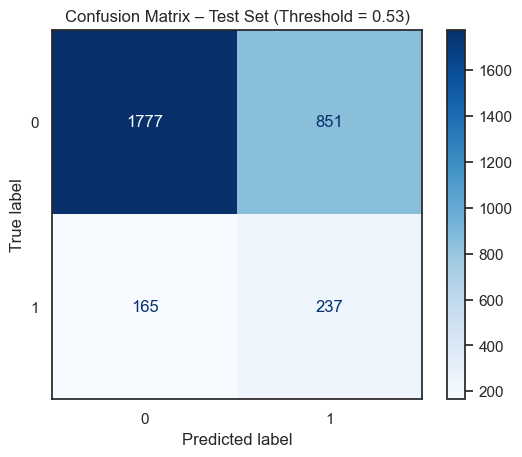

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# scoring test data X_test_non_tree_sel
PROB_THRESHOLD = THRESHOLD_OPT
OUTPUT_PATH = "test_predictions_all_features_with_proba.csv"

# 1) Predict probabilities on test set
if hasattr(best_model, "predict_proba"):
    y_test_proba = best_model.predict_proba(X_test_non_tree_sel)[:, 1]
else:
    scores = best_model.decision_function(X_test_non_tree_sel)
    y_test_proba = 1 / (1 + np.exp(-scores))

# 2) Build output table: all features + probability + configurable class
predictions_df_test = X_test_non_tree_sel.copy()
predictions_df_test["predicted_probability"] = y_test_proba
predictions_df_test["predicted_class"] = (y_test_proba >= PROB_THRESHOLD).astype(int)
predictions_df_test["y_true"] = y_test.values

display(predictions_df_test.head())

# 3) Export predictions
predictions_df_test.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH

# 4) Confusion Matrix (TEST)
cm = confusion_matrix(
    y_test,
    predictions_df_test["predicted_class"]
)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0, 1]
).plot(cmap="Blues")

plt.title(f"Confusion Matrix – Test Set (Threshold = {PROB_THRESHOLD})")
plt.show()

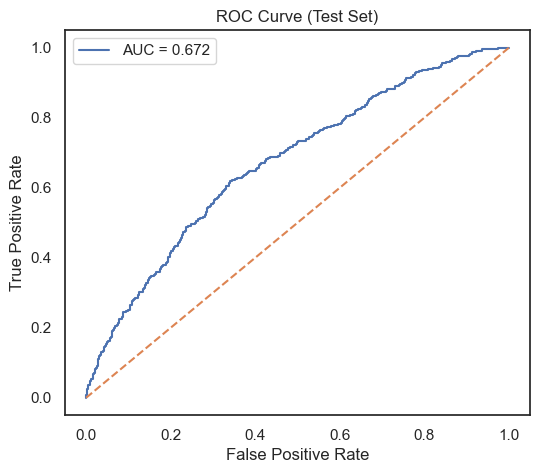

In [ ]:
from sklearn.metrics import roc_curve, auc

y_test_proba = model.predict_proba(X_test_non_tree_sel)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()

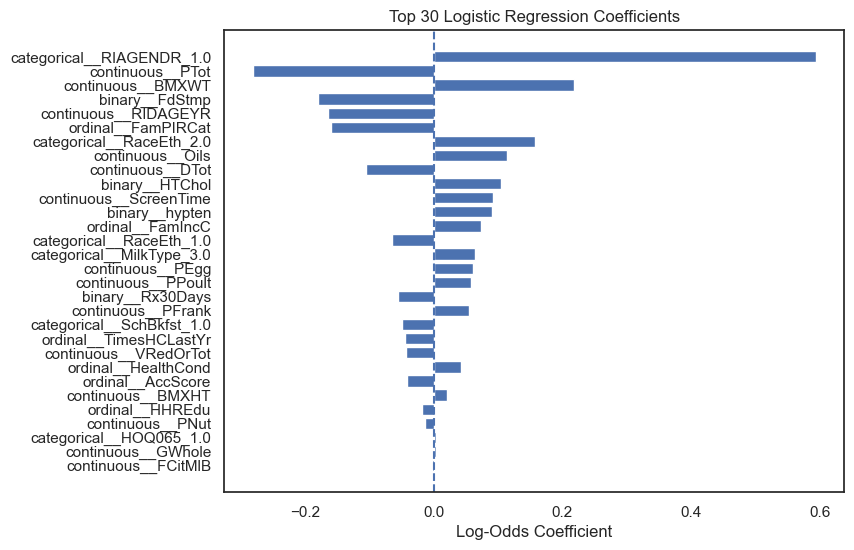

In [ ]:
# Top features contribution
coef_df = pd.DataFrame({
    "feature": X_train_non_tree_sel.columns,
    "coef": model.coef_[0]
})

top = coef_df.reindex(
    coef_df.coef.abs().sort_values(ascending=False).index
).head(30)

plt.figure(figsize=(8, 6))
plt.barh(top.feature, top.coef)
plt.axvline(0, linestyle="--")
plt.xlabel("Log-Odds Coefficient")
plt.title("Top 30 Logistic Regression Coefficients")
plt.gca().invert_yaxis()
plt.show()

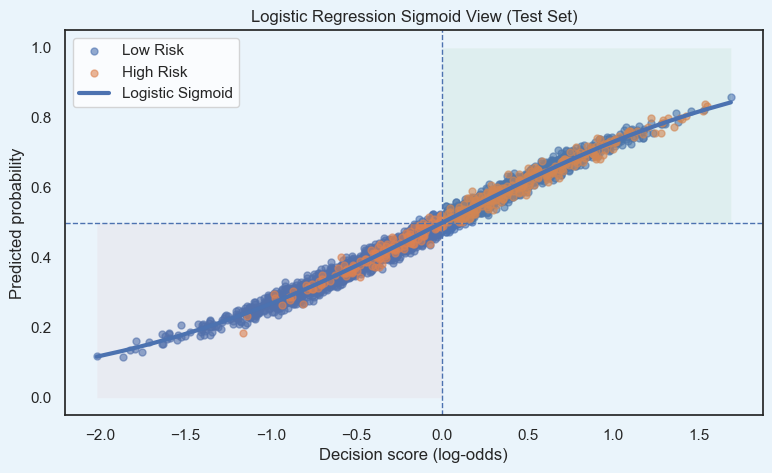

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Scores & probabilities
z = model.decision_function(X_test_non_tree_sel)
p = sigmoid(z)

# Sort for smooth curve
order = np.argsort(z)
z_sorted = z[order]
p_sorted = p[order]

# Add small vertical jitter for visualization only
rng = np.random.default_rng(42)
p_jitter = p + rng.normal(0, 0.015, size=len(p))

# Masks
mask_low = (y_test == 0)
mask_high = (y_test == 1)

plt.figure(figsize=(9, 5), facecolor="#eaf4fb")
ax = plt.gca()
ax.set_facecolor("#eaf4fb")

# Scatter points
plt.scatter(z[mask_low], p_jitter[mask_low],
            alpha=0.6, label="Low Risk",
            s=25)

plt.scatter(z[mask_high], p_jitter[mask_high],
            alpha=0.6, label="High Risk",
            s=25)

# Sigmoid curve
plt.plot(z_sorted, p_sorted, linewidth=3, label="Logistic Sigmoid")

# Thresholds
plt.axhline(0.5, linestyle="--", linewidth=1)
plt.axvline(0.0, linestyle="--", linewidth=1)

# Risk regions
plt.fill_between(z_sorted, 0.5, 1,
                 where=(p_sorted >= 0.5),
                 alpha=0.08)

plt.fill_between(z_sorted, 0, 0.5,
                 where=(p_sorted < 0.5),
                 alpha=0.05)

# Labels & title
plt.xlabel("Decision score (log-odds)")
plt.ylabel("Predicted probability")
plt.title("Logistic Regression Sigmoid View (Test Set)")

plt.legend()
plt.show()

In [ ]:
# Save a scoring bundle to PKL
import joblib

# Pick the trained model you want to deploy
# (use your final chosen model variable name)
final_model = best_model  # or best_non_tree_models["LogisticRegression_L1"]

# Feature schema from training artifacts
bundle = {
    "model": final_model,  # LogisticRegression_L1
    "preprocessor": non_tree_preprocessor,  # fitted ColumnTransformer
    "raw_input_columns": list(X_train_nontree.columns),  # RAW input columns expected by preprocessor
    "post_feature_names": list(X_train_non_tree_df.columns),  # output cols of preprocessor
    "selected_features": list(X_train_non_tree_sel.columns),  # exact cols used by the model
    # store a default threshold (you can overwrite at scoring time)
    "default_threshold": PROB_THRESHOLD
}

joblib.dump(bundle, "youthdiabetes_scoring_bundle.pkl")
print("Saved: youthdiabetes_logisticL1_scoring_bundle.pkl")


Saved: youthdiabetes_logisticL1_scoring_bundle.pkl
